# Proyecto Final: Telecomunicaciones: identificar operadores ineficaces

### Descripción del proyecto

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.


### Descripción de los datos

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)


El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

## 📚 Tabla de Contenidos

* **1. Carga y preparación inicial**
    * 1.1. Cargar librerías
    * 1.2. Cargar datasets
    * 1.3. Visualización inicial de los datos
***
* **2. Exploración y limpieza de los datos**
    * 2.1. Análisis de estructura
    * 2.2. Estadísticos descriptivos
    * 2.3. Análisis temporal
    * 2.4. Mejorar la calidad de los datos
        * 2.4.1. Remoción de duplicados
        * 2.4.2. Tratamiento de valores ausentes
        * 2.4.3. Corrección de valores extremos
***
* **3. Identificación de operadores ineficaces**
    * 3.1. Cálculo de eficiencia en métricas clave
        * 3.1.1. Tasa de llamadas perdidas
        * 3.1.2. Tiempo de espera promedio
        * 3.1.3. Radio de llamadas salientes
    * 3.2. Conclusiones sobre las métricas clave
    * 3.3. Establecer los umbrales de ineficiencia
    * 3.4. Segmentación y clasificación de operadores
        * 3.4.1. Graficar los operadores ineficientes
***
* **4. Análisis de relaciones entre variables**
    * 4.1. Análisis de cohortes
    * 4.2. Evolución de métricas por cohorte y semana
    * 4.3. Matriz de correlación entre métricas clave
***
* **5. Hipótesis y pruebas estadísticas**
    * 5.1. Elaboración de hipótesis
    * 5.2. Selección y justificación de pruebas estadísticas
    * 5.3. Pruebas de normalidad y varianza de las muestras
    * 5.4. Ejecución de pruebas ANOVA
    * 5.5. Interpretación de resultados
***
* **6. Conclusiones y recomendaciones**
    * 6.1. Resumen de hallazgos del análisis y conclusiones
    * 6.2. Recomendaciones operativas y líneas futuras de análisis
        * 6.2.1. Recomendaciones operativas
        * 6.2.2. Líneas futuras de análisis

# 1. Carga y preparación inicial

## 1.1. Cargar librerías  


In [1]:
# Cargar librerías 

%pip install seaborn
%pip install matplotlib 
%pip install pingouin 
%pip install scipy

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta
from scipy.stats import f_oneway
from scipy.stats import levene
from scipy.stats import shapiro
import pingouin as pg
from scipy.stats import kruskal

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1.2. Cargar datasets  


In [2]:
# Cargar datasets

calls = pd.read_csv('telecom_dataset_us.csv')
clients = pd.read_csv('telecom_clients_us.csv')

## 1.3. Visualización inicial de los datos

In [3]:
# Mostrar los conjuntos de datos

# Llamadas
print("Dataset Llamadas: \n", calls.head())

Dataset Llamadas: 
    user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25  


In [4]:
# Aplicar el metodo info al df calls

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [5]:
# Clientes

print("Dataset Clientes: \n", clients.head())

Dataset Clientes: 
    user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16


In [6]:
# Aplicar el metodo info al df clients

clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


# 2. Exploración y limpieza de los datos

## 2.1 Análisis de estructura 

#### Calls

In [7]:
# Mostrar valores unicos para las columnas

print(f"El numero de valores unicos para cada columna es: \n{calls.nunique()}")

El numero de valores unicos para cada columna es: 
user_id                 307
date                    119
direction                 2
internal                  2
operator_id            1092
is_missed_call            2
calls_count             502
call_duration          5373
total_call_duration    6040
dtype: int64


In [8]:
# Mostrar los valores minimos y maximos de las columnas

print(f"Los valores minimos de las columnas son: \n{calls.min()}")
print()
print(f"Los valores maximos de las columnas son: \n{calls.max()}")

Los valores minimos de las columnas son: 
user_id                                   166377
date                   2019-08-02 00:00:00+03:00
direction                                     in
internal                                   False
operator_id                             879896.0
is_missed_call                             False
calls_count                                    1
call_duration                                  0
total_call_duration                            0
dtype: object

Los valores maximos de las columnas son: 
user_id                                   168606
date                   2019-11-28 00:00:00+03:00
direction                                    out
internal                                    True
operator_id                             973286.0
is_missed_call                              True
calls_count                                 4817
call_duration                             144395
total_call_duration                       166155
dtype: object


#### Observaciones sobre la estructura del df Calls:

La columna 'internal', aparece como tipo object, sin embargo las información que posee muestra una respuesta booleana. Parece que esta columna tiene 118 valores ausentes, asi que tendremos que averiguar si es posible obtener los contenidos basandonos en la data de las otras columnas. Es necesario transformar los tipos de datos de la columna 'date' e 'internal', asi como posiblemente de 'direction' al solamente haber dos posibles direcciones de llamada (in/out).

En cuestion de rangos min-max, podemos destacar que el rango de fechas consta de aproximadamente cuatro meses entre agosto y noviembre de 2019. El conteo de llamadas fluctua entre 1 y 4817, mientras que la duracion de la llamada va de zero hasta 144,395 (Lo que representa mas de 40 horas!) y siendo la duracion total inclusive mas longeva con 166155 segundos (46.15 horas) Es necesario investigar si estos valores se tratan de errores en la recoleccion de los datos o simplemente de 'outliers'.


#### Clients


In [9]:
# Mostrar valores unicos para las columnas

print(f"El numero de valores unicos para cada columna es: \n{clients.nunique()}")

El numero de valores unicos para cada columna es: 
user_id        732
tariff_plan      3
date_start      73
dtype: int64


In [10]:
print(f"Las fechas de comienzo de clientes se encuentran entre {clients['date_start'].min()} y {clients['date_start'].max()}")

Las fechas de comienzo de clientes se encuentran entre 2019-08-01 y 2019-10-31


#### Observaciones sobre la estructura del df Clients:

Los tipos de datos parecen estar correctos y no encontramos valores ausentes en 'clients'. Es interesante saber que tenemos solamente usuarios unicos (cada fila representa a un usuario) y solamente 3 tipos diferentes de planes/tarifas. Las fechas de comienzo de clientes arrancan anticipadamente al df calls por un dia y 'clients' cierra con su fecha mas tardia aproximadamente un mes antes que la ultima data de 'calls'. 


## 2.2 Estadísticos descriptivos

En esta sección visualizaremos los datasets por medio del método describe para obtener las estadísticas numéricas principales de los conjuntos para después crear gráficas de su distribución y así tener un mejor entendimiento de su balance y valores, como de sus anomalías.

#### Calls

In [11]:
# Mostrar estadísticos descriptivos
round(calls.describe(), 2)

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.00,45730.00,53902.00,53902.00,53902.00
mean,167295.34,916535.99,16.45,866.68,1157.13
std,598.88,21254.12,62.92,3731.79,4403.47
min,166377.00,879896.00,1.00,0.00,0.00
25%,166782.00,900788.00,1.00,0.00,47.00
50%,167162.00,913938.00,4.00,38.00,210.00
75%,167819.00,937708.00,12.00,572.00,902.00
max,168606.00,973286.00,4817.00,144395.00,166155.00


    Podemos observar así que las columnas 'calls_count', 'call duration' y 'total_call_duration' tienen valores máximos inusualmente altos para sus promedios (y para lo que debería ser una llamada de soporte/servicio al cliente), lo cual podría ser un punto de interés para el análisis posterior.


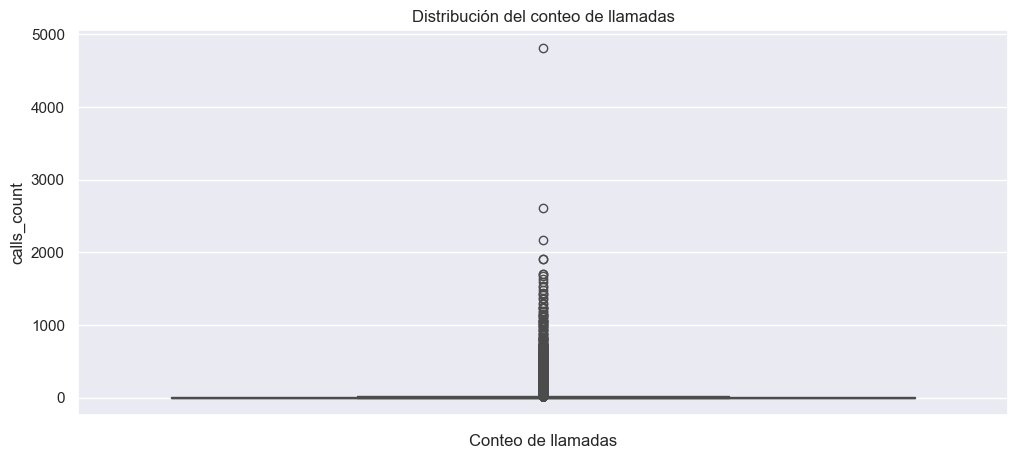

In [12]:
#### Crear gráficas de distribución del conteo de llamadas

# Establecer estilo general
sns.set(style='darkgrid')

# Gráfico de distribución del conteo de llamadas
plt.figure(figsize=(12, 5))
sns.boxplot(calls['calls_count'])
plt.title("Distribución del conteo de llamadas")
plt.xlabel("Conteo de llamadas")

plt.show()

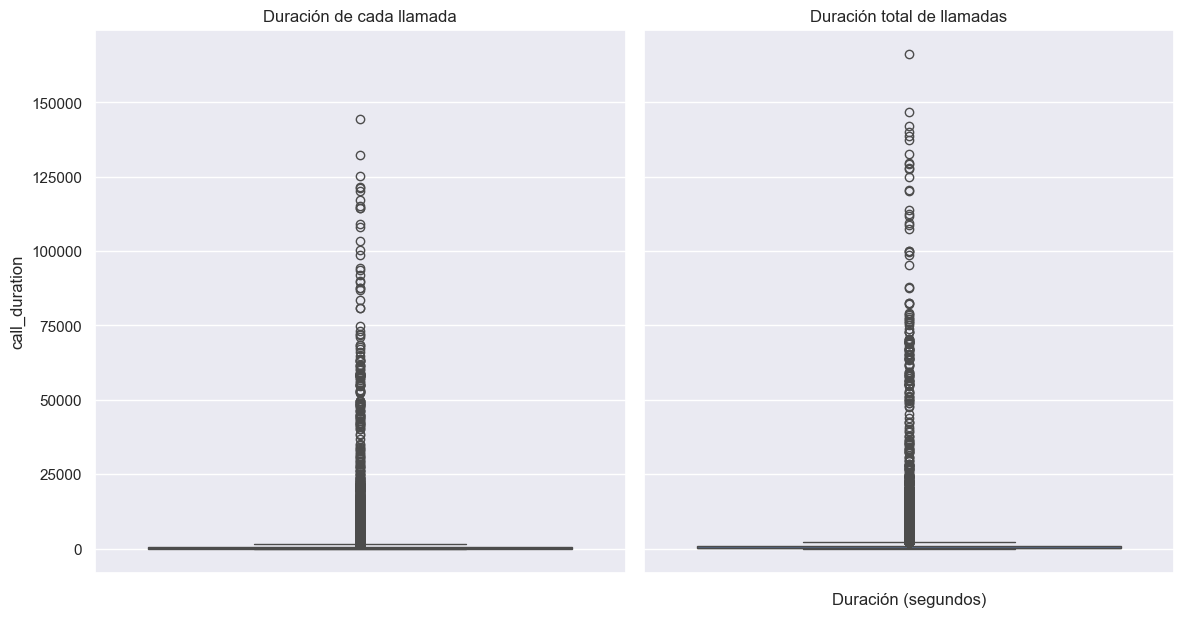

In [13]:
#### Crear boxplots para observar la distribución de la duración de las llamadas

# Creamos los subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # 1 fila, 2 columnas

# Boxplot de la duración de las llamadas
sns.boxplot(data=calls['call_duration'], ax=axes[0])
axes[0].set_title('Duración de cada llamada')

# Boxplot de la duración total de las llamadas
sns.boxplot(data=calls['total_call_duration'], ax=axes[1])
axes[1].set_title('Duración total de llamadas')

# Mostrar los gráficos
plt.tight_layout()
plt.xlabel("Duración (segundos)")
plt.show()

    En los el gráfico de distribución del conteo de llamadas, podemos observar que la mayoría de los clientes tienen un conteo de llamadas bajo (el 75% de los usuarios tienen un conteo menor a 12), con algunos clientes que tienen un conteo significativamente más alto. Esto podría indicar que algunos clientes son realmente activos, aunque quizás sea un poco temprano para inferir posibles causas.

    Los boxplots referentes a la duración de las llamadas muestran un patrón similar: el 75% de las llamadas está por debajo de los 600 segundos mientras en duración total el número es 902. Hay una gran cantidad de registros anómalos que deberán tratarse a lo largo del trabajo de analisis. 

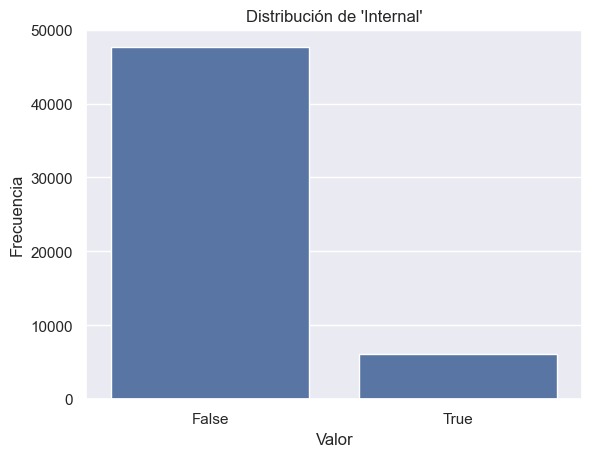

In [14]:
#### Crear gráfica de la distribución de la columna 'internal'

# Distribución de la columna 'internal'
sns.countplot(data=calls, x='internal')
plt.title("Distribución de 'Internal'")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")

plt.show()

    De acuerdo con el último gráfico de barras, la gran mayoría de llamadas son externas. Solamente hay dos respuestas posibles al ser una columna booleana.

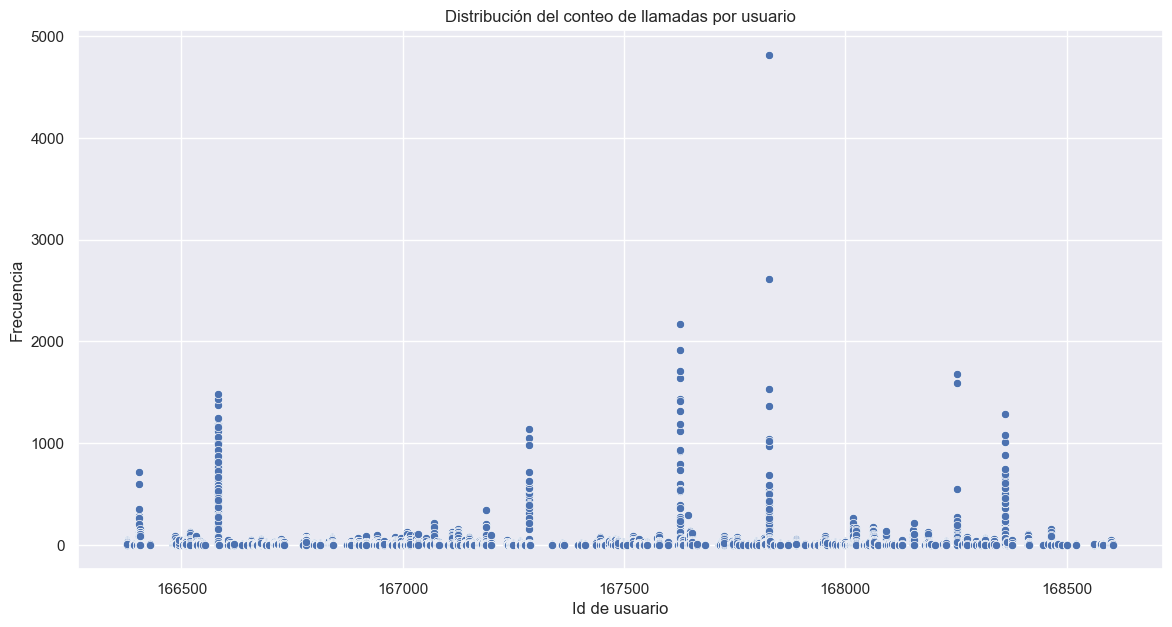

In [15]:
#### Crear gráfica de la distribución del conteo de llamadas por usuario

# Definir tamaño del gráfico
plt.figure(figsize=(14, 7))

# Distribución de 'calls_count'
sns.scatterplot(data=calls, x='user_id', y='calls_count')
plt.title("Distribución del conteo de llamadas por usuario")
plt.xlabel("Id de usuario")
plt.ylabel("Frecuencia")
plt.show()

    Para el gráfico anterior podemos decir que solamente hay algunos cuantos usuarios anómalos que hacen una cantidad de llamadas diarias que podemos considerar no solamente raras sino también poco probables. Es posible que se trate de un problema de recolección de datos con esos id de usuario, aunque para cuestiones de este análisis simplemente nos limitaremos a recortar los valores extremos para evitar afectar la integridad de los datos y poder así trazar hipótesis al respecto y sacar conclusiones acerca de dichos resultados. 

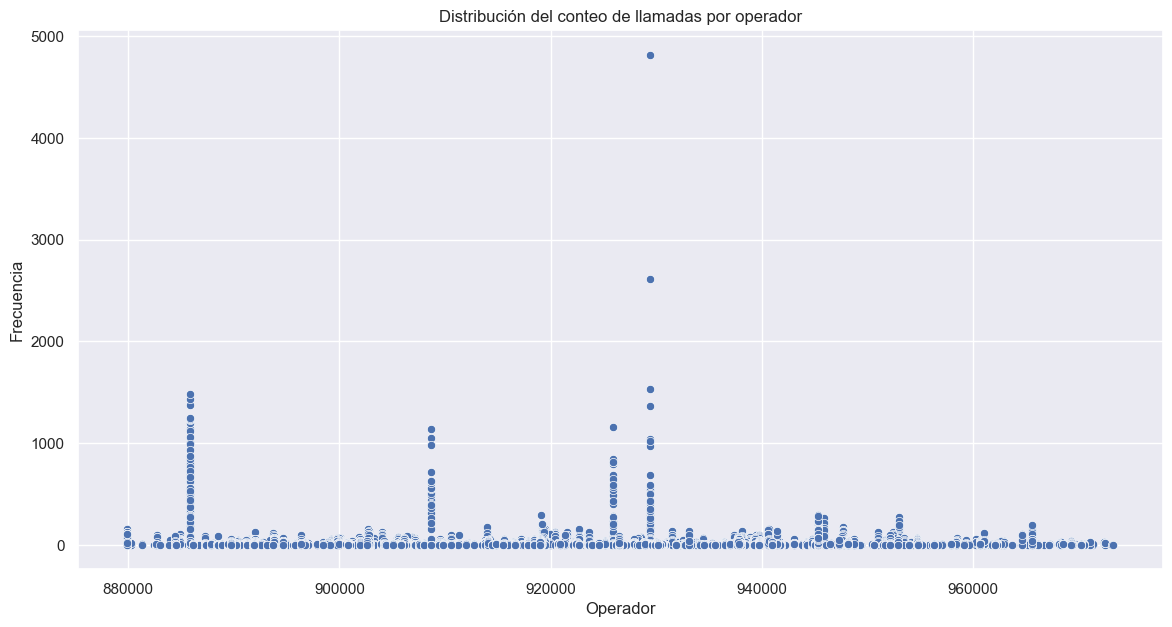

In [16]:
#### Crear gráfica de la distribución del conteo de llamadas por operador

# Definir tamaño del gráfico
plt.figure(figsize=(14, 7))

# Distribución de 'calls_count' por operador
sns.scatterplot(data=calls, x='operator_id', y='calls_count')
plt.title("Distribución del conteo de llamadas por operador")
plt.xlabel("Operador")
plt.ylabel("Frecuencia")

plt.show()

    El anterior gráfico nos muestra que hay ciertos operadores que tienen un número anormalmente alto de llamadas en un solo día. Esto más allá de ciertos empleados "super eficientes" nos indica posibles duplicados o errores en los datos que habrá que corregir (al igual que en el número de llamadas por usuario).

#### Observaciones de los estadísticos descriptivos del df Calls:

- Las columnas `calls_count`, `call_duration` y `total_call_duration` presentan valores máximos considerablemente altos en comparación con sus medias y medianas, lo que indica la presencia de valores atípicos (outliers).
- La mayoría de los registros tienen un conteo de llamadas bajo (el 75% está por debajo de 12 llamadas), pero existen algunos usuarios y operadores con conteos anormalmente altos, posiblemente por errores de captura o casos excepcionales.
- En cuanto a la duración de las llamadas, el 75% de los registros tiene una duración menor a 600 segundos, pero existen llamadas con duraciones extremadamente largas (más de 10,000 segundos), lo que también sugiere outliers.
- La variable `internal` muestra que la mayoría de las llamadas son externas, y solo hay dos valores posibles (True/False), aunque existen algunos valores ausentes.
- Se identificaron valores extremos en las métricas principales, por lo que será necesario tratarlos para evitar que distorsionen los análisis posteriores.




#### Clients

In [17]:
# Recordar la estructura del df

clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


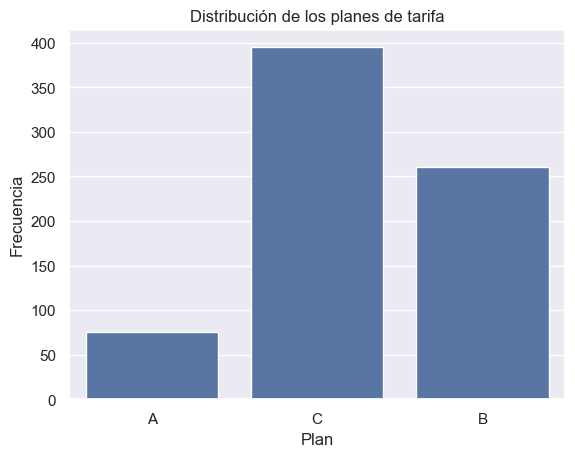

In [18]:
# Distribución de los planes de tarifa:

sns.countplot(data=clients, x='tariff_plan')

plt.title("Distribución de los planes de tarifa")
plt.xlabel("Plan")
plt.ylabel("Frecuencia")

plt.show()

#### Observaciones de los estadísticos descriptivos del df Clients:

El anterior gráfico realmente no aporta mucha información sin tener mayor contexto al respecto de lo que podemos observar, por lo que será necesario profundizar en el análisis temporal de las siguientes etapas.
A "primera vista" solamente podemos señalar lo obvio: 
- Tenemos 732 usuarios únicos
- 'A' tiene alrededor de 75 usuarios, 'B' uno poco más de 250 y 'C' casi 400
- Tenemos también una fecha de inicio, que ronda el último tercio de año en el 2019

## 2.3 Análisis temporal

#### Calls

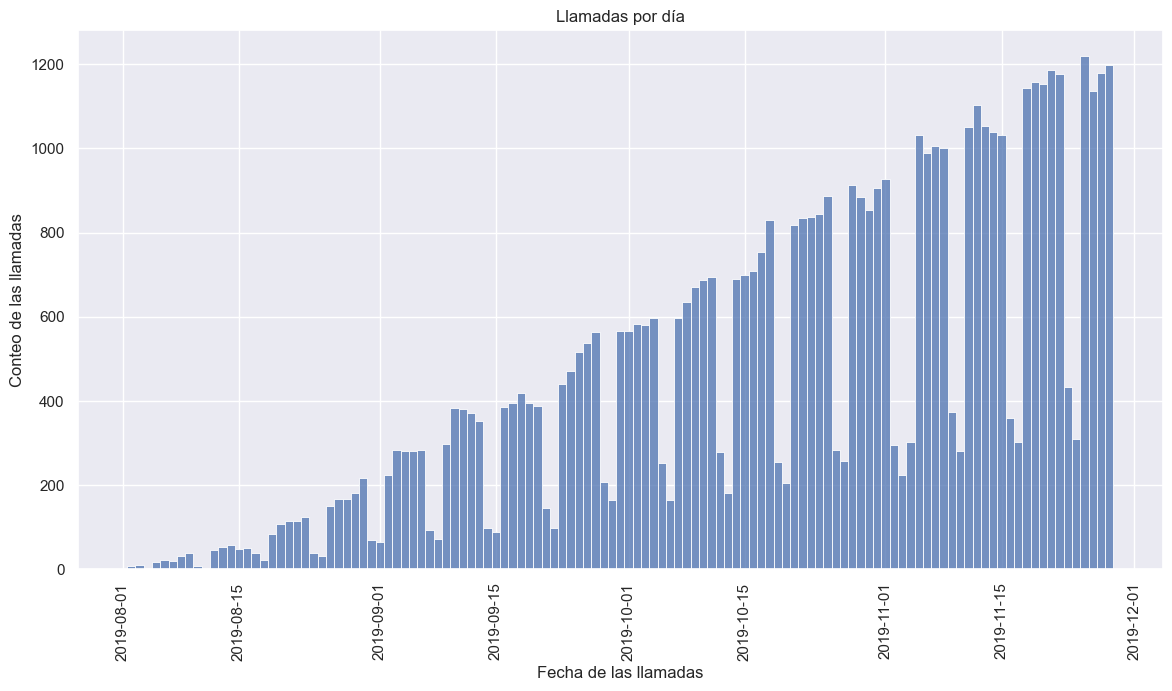

In [19]:
# Convertir la columna date a solamente fecha
calls['date'] = pd.to_datetime(calls['date']).dt.date

# Crear figura y darle tamano
plt.figure(figsize=(14, 7))

# Crear histograma que muestre la distribución temporal de los datos de este df
sns.histplot(data=calls, x='date')
plt.title("Llamadas por día")
plt.xlabel("Fecha de las llamadas")
plt.ylabel("Conteo de las llamadas")
plt.xticks(rotation=90)
plt.show()

#### Observaciones del análisis temporal del df Calls:

En el archivo anterior podemos observar dos patrones: el crecimiento sostenido en el número de llamadas desde el comienzo de los datos hasta su final. Lo segundo es que tenemos 5 días de mayor actividad seguidos de 2 días en los que la cantidad de llamadas representa solamente un 25%-35% de los anteriores 5. Este tipo de crecimiento constante no indica que o si bien se están colectando cada vez más datos o que el proyecto tiene un ritmo acelerado de crecimiento.


#### Clients

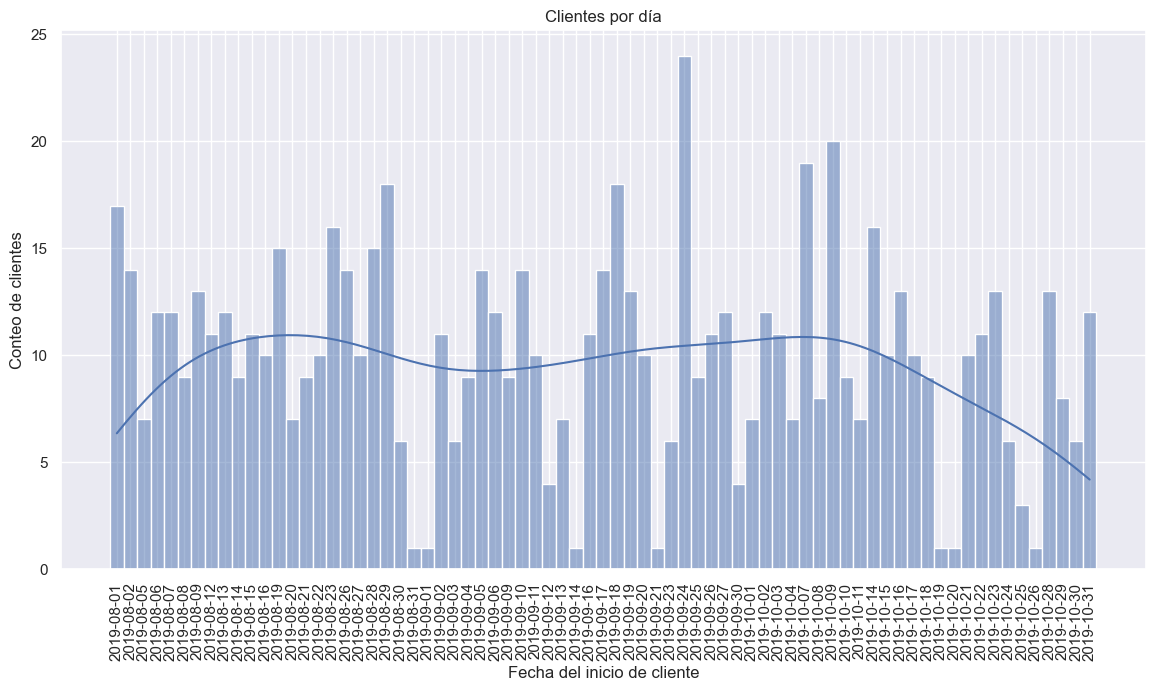

In [20]:
# Crear figura y darle tamano
plt.figure(figsize=(14, 7))

# Crear histograma que muestre la distribución temporal de los datos de este df
sns.histplot(
    data=clients.sort_values(by='date_start'),
    x='date_start',
    kde=True
)

plt.title("Clientes por día")
plt.xlabel("Fecha del inicio de cliente")
plt.ylabel("Conteo de clientes")
plt.xticks(rotation=90)
plt.show()

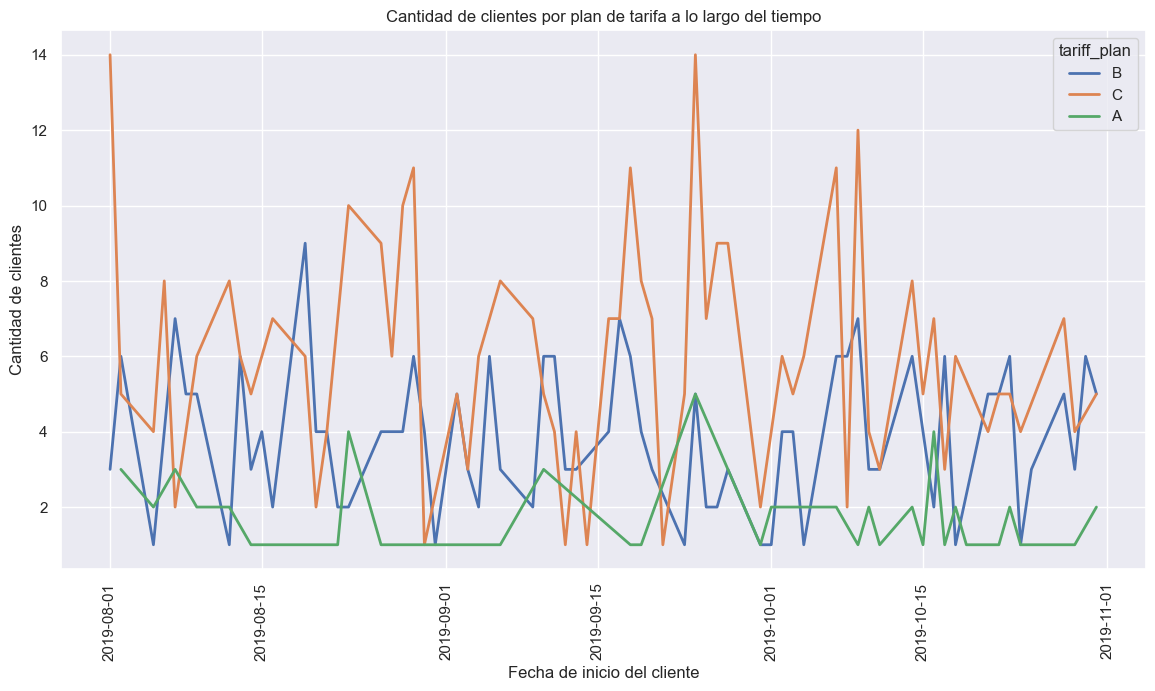

In [21]:
#### Mostrar la cantidad de clientes por plan de tarifa a lo largo del tiempo

# Convertir la columna date_start a tipo fecha y agrupar por fecha y plan de tarifa
clients['date_start'] = pd.to_datetime(clients['date_start']).dt.date
clients_grouped = clients.groupby(['date_start', 'tariff_plan']).size().reset_index(name='count')

# Crear el gráfico
plt.figure(figsize=(14, 7))
sns.lineplot(data=clients_grouped,
            x='date_start',
            y='count',
            hue='tariff_plan', 
            linewidth=2, 
            markers='o')

plt.title("Cantidad de clientes por plan de tarifa a lo largo del tiempo")
plt.xlabel("Fecha de inicio del cliente")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=90)
plt.show()

#### Observaciones del análisis temporal del df Clients:

Esta nueva visualización ("Clientes por día") nos permite responder una de las preguntas/posibilidades recién planteadas: El número de clientes no aumentó y no muestra ningún patrón claro a primera vista. No es sino mediante el trazado de la línea de kde(kernel density estimate) que podemos vislumbrar una tendencia a la baja hacia el final de los datos. 

Aquí podemos empezar a teorizar una hipótesis al tratarse de un servicio de atención al cliente: si cada vez hay más llamadas de asistencia, mientras los clientes comienzan a irse es lógico suponer que algo no anda bien con el producto/servicio o la atención/soporte mismo que reciben.

Hay que mencionar también que no todos los días se registran nuevos clientes, sino que sigue el mismo patrón observado en el gráfico "llamadas por día" de 5 días de actividad normal por dos días de nula o muy bajos registros. Aquí podemos confirmar lo propuesto anteriormente: de Lunes a Viernes se presentan los eventos de forma regular y es solamente los fines de semana cuando estos cesan o disminuyen considerablemente.

Respecto al segundo gráfico, podemos decir que no existe una tendencia clara en ninguna de las 3 tarifas sino una constante fluctuación dentro de un rango particular para cada uno de los planes.



## 2.4  Mejorar la calidad de los datos


#### Calls

Recordemos las anomalías detectadas en el análisis exploratorio de datos y en las cuales nos enfocaremos para preparar este dataset:
- La columna 'internal', aparece como tipo object, sin embargo las información que posee muestra una respuesta booleana
- La columna 'date' no aparece como formato datetime
- La columna 'internal' tiene 118 valores ausentes
- La columna 'operator_id' tiene 7172 valores ausentes
- Existen valores extremos en las columnas 'calls_count', 'call_duration' y 'total_call_duration' 

### 2.4.1. Remoción de duplicados 

In [22]:
#### Remover duplicados

# Mostrar el número de filas y columnas del df calls
print(f"Número de filas y columnas en el df calls: {calls.shape}")

calls = calls.drop_duplicates().reset_index(drop=True)

# Mostrar el número de filas y columnas del df calls despues de eliminar duplicados
print(f"Número de filas y columnas en el df calls después de eliminar duplicados: {calls.shape}")

# Verificar si hay duplicados
print(f"¿Hay duplicados en el df calls? {calls.duplicated().any()}")

Número de filas y columnas en el df calls: (53902, 9)
Número de filas y columnas en el df calls después de eliminar duplicados: (49002, 9)
¿Hay duplicados en el df calls? False


### 2.4.2. Detección y tratamiento de valores ausentes    


In [23]:
##### Tratar los valores ausentes en la columna 'internal'

### Verificar si 'user_id' es siempre el mismo para el mismo operador cuando el 'operator_id' no esta ausente.
operator_filtered = calls[calls['operator_id'].notna()] # Filtrar las filas donde 'operator_id' no es nulo

# Verificar si 'user_id' es siempre el mismo para el mismo operador
multiple_operators = 0  # contador para usuarios con múltiples operadores

# Agrupar por 'user_id' y 'operator_id' y contar los valores únicos de 'operator_id'
for user_id, group in operator_filtered.groupby('user_id'):
    if group['operator_id'].nunique() > 1:
        multiple_operators += 1 # Incrementar el contador de usuarios con múltiples operadores
print(f"Existen {multiple_operators} usuarios con múltiples operadores")


Existen 183 usuarios con múltiples operadores


    Descartando la teoría de tener un operador único para cada usuario, no hay una manera discernible de obtener los valores ausentes para esta columna. Conocer el operador de cada evento es fundamental ya que nuestro análisis esta enfocado en saber las métricas de cada uno de ellos. La mejor opción para tratar esas filas es removerlas del dataset para así poder realizar las pruebas necesarias sin mayores afectaciones.


In [24]:
# Remover las filas con 'operator_id' ausente
calls = calls[calls['operator_id'].notna()]

In [ ]:
#### Tratar los valores ausentes en la columna 'internal'

### Verificar si 'internal' es siempre el mismo para la misma dirección de llamada

# Filtrar las filas donde 'internal' es nan
internal_nan = calls[calls['internal'].isna()]

# Verificar el número de valores únicos de las columnas cuando 'internal' es nulo
internal_nan.nunique()

user_id                30
date                   36
direction               1
internal                0
operator_id            41
is_missed_call          2
calls_count             3
call_duration          49
total_call_duration    51
dtype: int64

    Podemos observar que para las filas en las cuales 'internal' es nan, solamente tenemos un tipo de dirección. Ahora es necesario verificar cuál es y si en el df original, las llamadas con esa dirección pueden darnos la información acerca de los valores ausentes.   

In [27]:
# Comprobar el valor de 'direction' en los registros con 'internal' nulo
print("Valores de 'direction' cuando 'internal' es nulo:",  internal_nan['direction'].unique())

# Comprobar si el valor de 'internal' en el dataframe original duando la dirección es 'in'  
print("Valor de internal en el df 'calls' cuando la dirección es 'in'",
       calls[calls['direction'] == 'in']['internal'].unique())


Valores de 'direction' cuando 'internal' es nulo: ['in']
Valor de internal en el df 'calls' cuando la dirección es 'in' [False True nan]



    En este caso la comprobación realizada en la celda anterior nos dice que aunque en todas las instancias en las cuales 'internal calls' es nulo, la columna 'direction' == 'in', pero esto no significa que eso sea aplicable para el df en general (en las llamadas con dirección entrante {'direction' == 'in'}, la columna 'internal' todavía puede tener cualquier valor: True/False/Na). 
    Por lo tanto, para mantener la integridad de los datos, es necesario remover las filas que presentan NaNs, aunque cabe mencionar que en esta ocasión el impacto es mínimo al representar un porcentaje muy bajo del largo del df.

In [31]:
##### Hacer los ajustes restantes en los tipos de datos del df:

# Descartar los NaNs de la columna 'internal'
calls = calls[calls['internal'].notna()]

# Transformar la columna 'date' a tipo datetime
calls['date'] = pd.to_datetime(calls['date'])

# Transformar la columna 'internal' a tipo booleano
calls['internal'] = calls['internal'].astype(bool)

In [32]:
# Comprobar la información del dataframe 'calls' después de los cambios
calls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41491 entries, 1 to 49000
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41491 non-null  int64         
 1   date                 41491 non-null  datetime64[ns]
 2   direction            41491 non-null  object        
 3   internal             41491 non-null  bool          
 4   operator_id          41491 non-null  float64       
 5   is_missed_call       41491 non-null  bool          
 6   calls_count          41491 non-null  int64         
 7   call_duration        41491 non-null  int64         
 8   total_call_duration  41491 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.6+ MB


### 2.4.3. Corrección de valores extremos

In [44]:
##### Corregir los valores extremos en las columnas 'calls_count', 'call_duration' y 'total_call_duration'

# Hacer un agrupamiento para la columna 'calls_count' por día y verificar si existen valores extremos
calls_per_day = calls.groupby(['user_id', 'date'])['calls_count'].sum().reset_index()

# Calcular las estadísticas descriptivas de la columna 'calls_count' agrupada por día
calls_per_day.describe()

,user_id,date,calls_count
count,8586.000000,8586,8586.000000
mean,167213.519800,2019-10-20 05:42:58.616352256,62.569765
min,166377.000000,2019-08-02 00:00:00,1.000000
25%,166782.000000,2019-10-01 00:00:00,3.000000
50%,167109.000000,2019-10-24 00:00:00,12.000000
75%,167633.000000,2019-11-12 00:00:00,49.000000
max,168606.000000,2019-11-28 00:00:00,4425.000000
std,547.372783,NaN,209.923919


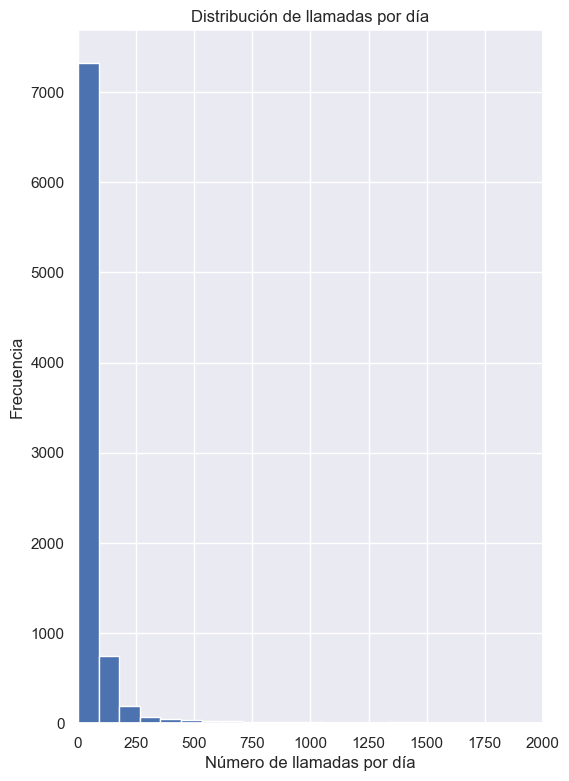

In [45]:
#### Trazar un histograma para visualizar la distribución de 'calls_count' por usuario
calls_per_day['calls_count'].hist(
    bins=50, 
    figsize=(6, 9))

# Etiquetas de los ejes, valores y título
plt.xlabel('Número de llamadas por día')
plt.ylabel('Frecuencia')
plt.title('Distribución de llamadas por día')
plt.xlim(0, 2000)  # Limitar el eje x para enfocarse en la mayoría de los datos

plt.show()

    Podemos confirmar que existe una anomalía en los datos ya que el anterior histograma nos hace ver claramente que el número de llamadas por día deja de ser visible en el bin que acumula la zona de las 400. Hay que encontrar entonces nuestros percentiles donde este número se dispara para así limitar nuestros datos sin perder integridad en ellos.

In [46]:
# Calcular percentiles para identificar valores extremos
percentiles = np.percentile(calls_per_day['calls_count'], [0, 25, 50, 75, 90, 95, 99, 100])

# Mostrar los percentiles calculados
print('Los percentiles 0 25 50 75 90 95 99 100 de la columna "calls_count" son: \n', percentiles.astype(int))

Los percentiles 0 25 50 75 90 95 99 100 de la columna "calls_count" son: 
 [   1    3   12   49  124  203  959 4425]


In [47]:
# Filtrar los datos para mostrar solo aquellos días con más de 500 llamadas
print(calls_per_day[calls_per_day['calls_count'] > 500].reset_index(drop=True))

# Calcular el porcentaje de días con más de 500 llamadas
percentile_500 = len(calls_per_day[calls_per_day['calls_count'] > 500]) / len(calls_per_day) * 100

# Mostrar el percentil que representan los valores filtrados
print("\n El percentil que representa el valor de 500 llamadas por día es:", 
        percentile_500)

     user_id       date  calls_count
0     166405 2019-11-18          537
1     166582 2019-08-19          644
2     166582 2019-08-20          517
3     166582 2019-08-21          688
4     166582 2019-08-22          556
..       ...        ...          ...
187   168361 2019-11-24         1454
188   168361 2019-11-25         1478
189   168361 2019-11-26         2030
190   168361 2019-11-27         1694
191   168361 2019-11-28         1798

[192 rows x 3 columns]

 El percentil que representa el valor de 500 llamadas por día es: 2.2361984626135567


#### Comentario sobre valores extremos en llamadas por día:

En este caso, el percentil 97 representa un valor de 500 llamadas por día, lo que indica que menos del 0.03% de los días, un usuario realiza más de 500 llamadas. Por esta razón haremos el corte en este punto, evitando afectar la integridad del dataframe al eliminar solamente los 258 valores del extremo superior del rango de la columna 'calls_count'.  

In [48]:
#### Eliminar los valores extremos en la columna 'calls_count'

# Mostrar el número de filas y columnas del df calls
print(f"Número de filas en el df calls: {len(calls)}")

# Filtrar los datos para mostrar solo aquellos usuarios con menos de 500 llamadas por día
calls = calls[calls['calls_count'] < 500]

# Mostrar el número de filas y columnas del df calls después de eliminar los valores extremos
print(f"Número de filas en el df calls después de eliminar los valores extremos: {len(calls)}")

Número de filas en el df calls: 40940
Número de filas en el df calls después de eliminar los valores extremos: 40940


In [49]:
##### Corregir los valores extremos en la columna 'call_duration'

# Verificar si hay valores extremos en la columna 'call_duration'
calls['call_duration'].describe()

count    40940.000000
mean       707.685613
std       1397.416942
min          0.000000
25%          0.000000
50%        100.000000
75%        726.000000
max       9994.000000
Name: call_duration, dtype: float64

In [50]:
# Obtener los percentiles para la columna 'call_duration'
print("Los percentiles 0, 25, 50, 75, 90, 95, 99 y 100 de la columna 'call_duration' son: \n",
        np.percentile(calls['call_duration'], [0, 25, 50, 75, 90, 95, 99, 100]).astype(int))

Los percentiles 0, 25, 50, 75, 90, 95, 99 y 100 de la columna 'call_duration' son: 
 [   0    0  100  726 2193 3564 7209 9994]


In [51]:
# Filtrar los datos para mostrar solo aquellos días con más de 1000 segundos de duración de llamada
calls_filtered = calls[calls['call_duration'] < 10000]

print("El percentil que representa el valor de 10000 segundos de duración de llamada es:", 
        len(calls_filtered) / len(calls) * 100, "\n")

print(f"Número de llamadas de más de 10000 segundos de duración: {len(calls) - len(calls_filtered)}")

El percentil que representa el valor de 10000 segundos de duración de llamada es: 100.0 

Número de llamadas de más de 10000 segundos de duración: 0


#### Comentario sobre los valores extremos en 'call_duration':

Para nuestra columna 'call_duration', el percentil 99 representa un valor de 10000 segundos, lo que indica que menos del 0.01% de las llamadas tienen una duración mayor a este valor. Al filtrar los valores extremos de esta columna, evitamos degradar la completidad del dataframe al eliminar solamente los valores del extremo superior de la columna 'call_duration'.

In [52]:
# Mostrar el número de filas y columnas del df calls
print(f"Número de filas en el df calls: {len(calls)}")

# Filtrar los datos para mostrar solo aquellos días con menos de 10000 segundos de duración de llamada
calls = calls[calls['call_duration'] < 10000]

# Mostrar el número de filas y columnas del df calls después de eliminar los valores extremos
print(f"Número de filas en el df calls después de eliminar los valores extremos: {len(calls)}")

Número de filas en el df calls: 40940
Número de filas en el df calls después de eliminar los valores extremos: 40940


In [53]:
##### Corregir los valores extremos en la columna 'total_call_duration'

# Verificar si hay valores extremos en la columna 'total_call_duration'
#  después de eliminar los valores extremos en 'call_duration'
calls['total_call_duration'].describe()

count    40940.000000
mean       951.347509
std       1674.281915
min          0.000000
25%         66.000000
50%        280.000000
75%       1043.250000
max      17146.000000
Name: total_call_duration, dtype: float64

In [54]:
# Comprobar los percentiles para la columna 'total_call_duration'
print("Los percentiles 0, 25, 50, 75, 90, 95, 99 y 100 de la columna 'total_call_duration' son: \n",
      np.percentile(calls['total_call_duration'], [0, 25, 50, 75, 90, 95, 99, 100]).astype(int))

Los percentiles 0, 25, 50, 75, 90, 95, 99 y 100 de la columna 'total_call_duration' son: 
 [    0    66   280  1043  2686  4290  8686 17146]


#### Comentario sobre los valores extremos en la columna 'total_call_duration':

Considerando que el valor máximo original para la columna 'total_call_duration' era de 166155, debemos de concluir que los valores actuales no son "extremos" y podemos continuar sin necesidad de hacer ningún otro recorte al dataframe.


#### Clients

In [55]:
# Verificar si existen duplicados en el df clients
print(f"Número de filas duplicadas en el df clients: {clients.duplicated().sum()}")

Número de filas duplicadas en el df clients: 0


#### Comentario sobre los valores extremos en el df Clients:

Para el df clients, no hemos encontrado anomalías significativas en sus valores o distribuciones que requieran corrección.

# 3. Identificación de Operadores Ineficaces

## 3.1 Cálculo de eficiencia en métricas clave

### 3.1.1 Tasa de llamadas perdidas (por operador)

In [56]:
#### Encontrar las metricas clave para identificar operadores ineficaces

# Tasa de llamadas perdidas y tomadas por operador
missed_per_operator = calls[calls['is_missed_call'] == True].groupby('operator_id').size().reset_index(name='missed_calls')
taken_per_operator = calls[calls['is_missed_call'] == False].groupby('operator_id').size().reset_index(name='taken_calls')

# Unir los dataframes de llamadas perdidas y tomadas por operador
operator_efficiency = pd.merge(missed_per_operator, taken_per_operator, on='operator_id', how='outer')

# Rellenar los valores NaN con 0
operator_efficiency.fillna(0, inplace=True)

# Calcular la tasa de llamadas perdidas por operador
operator_efficiency['missed_call_rate'] = np.round(operator_efficiency['missed_calls'] / (
    operator_efficiency['missed_calls'] + operator_efficiency['taken_calls']), 2)

# Convertir las columnas 'operator_id', 'missed_calls' y 'taken_calls' a tipo int
operator_efficiency['operator_id'] = operator_efficiency['operator_id'].astype(int)
operator_efficiency['missed_calls'] = operator_efficiency['missed_calls'].astype(int)
operator_efficiency['taken_calls'] = operator_efficiency['taken_calls'].astype(int) 

# Mostrar el dataframe con la tasa de llamadas perdidas y tomadas por operador
operator_efficiency

,operator_id,missed_calls,taken_calls,missed_call_rate
0,879896,47,69,0.41
1,879898,89,137,0.39
2,880020,6,14,0.30
3,880022,29,41,0.41
4,880026,87,95,0.48
...,...,...,...,...
1087,972410,2,2,0.50
1088,972412,2,3,0.40
1089,972460,3,4,0.43
1090,973120,1,1,0.50


Text(0.5, 1.0, 'Tasa de llamadas perdidas por operador')

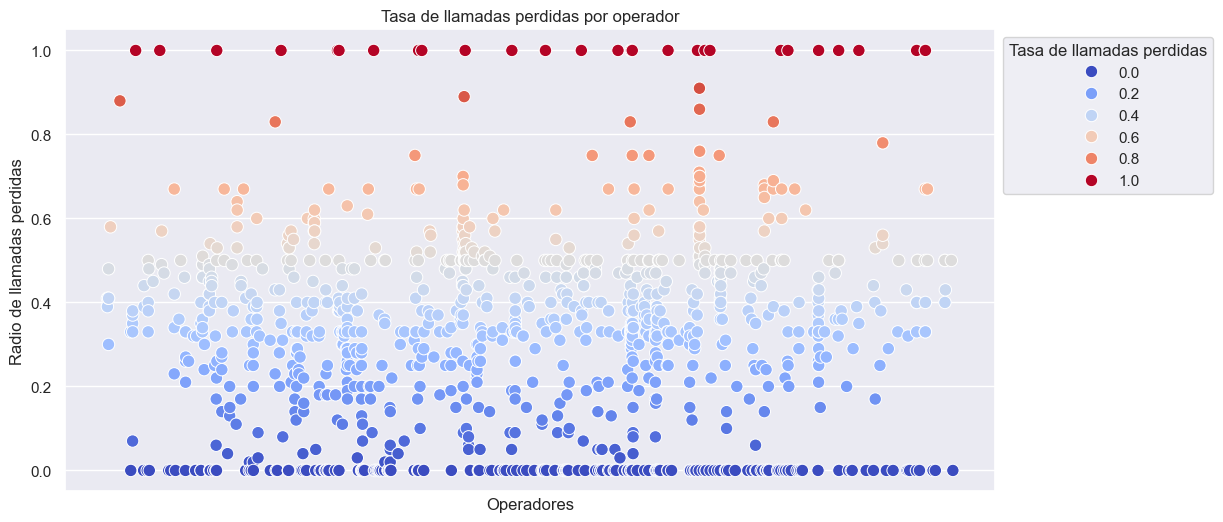

In [57]:
# Graficar la distribución de la tasa de llamadas perdidas por operador
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=operator_efficiency,
    x='operator_id',
    y='missed_call_rate',
    hue='missed_call_rate',
    palette='coolwarm',
    s=80
)
# Remover la leyenda y los xticks
plt.legend(title='Tasa de llamadas perdidas', bbox_to_anchor=(1, 1), loc='upper left')
plt.ylabel("Radio de llamadas perdidas")
plt.xlabel("Operadores")
plt.xticks([])

plt.title("Tasa de llamadas perdidas por operador")

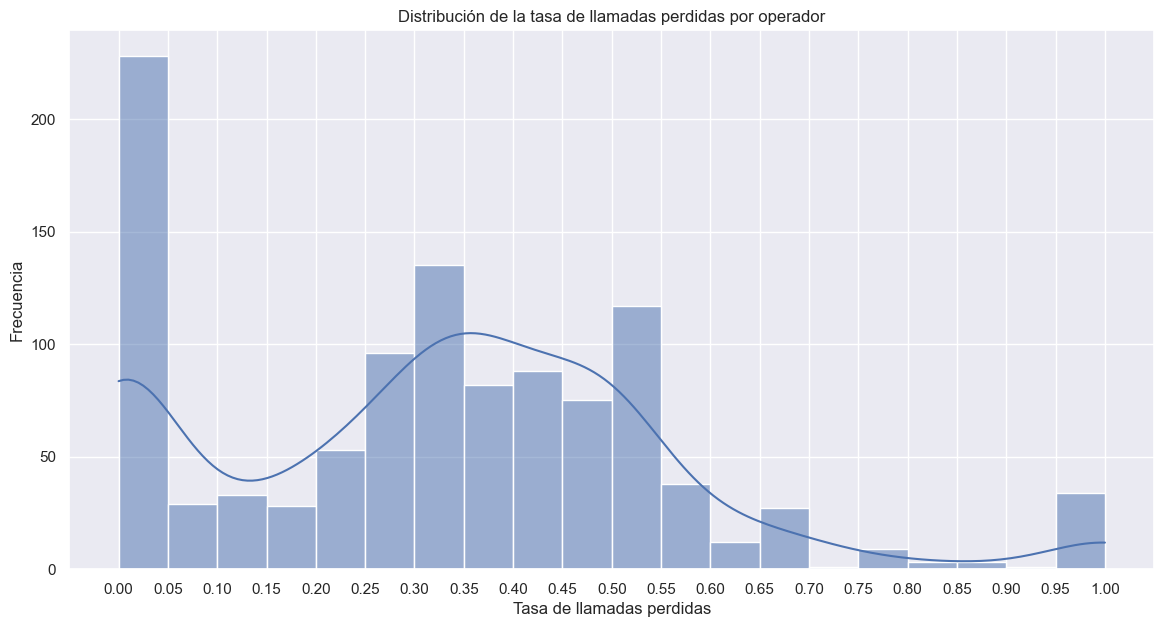

In [58]:
# Graficar la distribución de la tasa de llamadas perdidas por operador

# Crear figura y darle tamano
plt.figure(figsize=(14, 7))

sns.histplot(
    data=operator_efficiency,
    x='missed_call_rate',
    bins=20, kde=True
    )

plt.title("Distribución de la tasa de llamadas perdidas por operador")
plt.xlabel("Tasa de llamadas perdidas")
plt.ylabel("Frecuencia")
plt.xticks(np.arange(0, 1.05, 0.05))  # Ajustar los ticks del eje x

plt.show()

In [59]:
### Mostrar los percentiles de la tasa de llamadas perdidas por operador

# Calcular los percentiles de la tasa de llamadas perdidas por operador
percentiles_missed_calls = np.percentile(operator_efficiency['missed_call_rate'], [25, 50, 75, 80, 85, 90, 95, 99, 100])

# Mostrar los percentiles calculados
print("Los percentiles 25, 50, 75, 80, 85, 90, 95, 99 y 100 de la tasa de llamadas perdidas por operador son: \n",
      percentiles_missed_calls.astype(float))

Los percentiles 25, 50, 75, 80, 85, 90, 95, 99 y 100 de la tasa de llamadas perdidas por operador son: 
 [0.1375 0.33   0.47   0.5    0.5    0.57   0.69   1.     1.    ]


#### Observaciones sobre la tasa de llamadas perdidas por operador:

observarmos que la tasa de llamadas perdidas tiene su punto más elevado en 0 lo cual es muy positivo para la mayoría de agentes. Posteriormente, los datos se distribuyen casi normalmente alrededor del 30 al 50 porciento, lo que indica que una parte importante de los operadores tienen un área de oportunidad importante en cuestiones de eficiencia. Es recomendable por lo tanto realizar un análisis más detallado para identificar las causas de esta elevada tasa de llamadas perdidas (hacer comparativos históricos, comprobar estándares en la industria, etc.) 

Con los datos disponibles en nuestros dataset, es necesario verificar si la eficiencia (Tasa de llamadas perdidas) está correlacionada con la fecha de inicio del colaborador y de esta manera comprobar o descartar la siguiente hipótesis: Los operadores con menos experiencia tienen una mayor tasa de llamadas perdidas.

### 3.1.2 Tiempo de espera promedio 

Text(0, 0.5, 'Frecuencia')

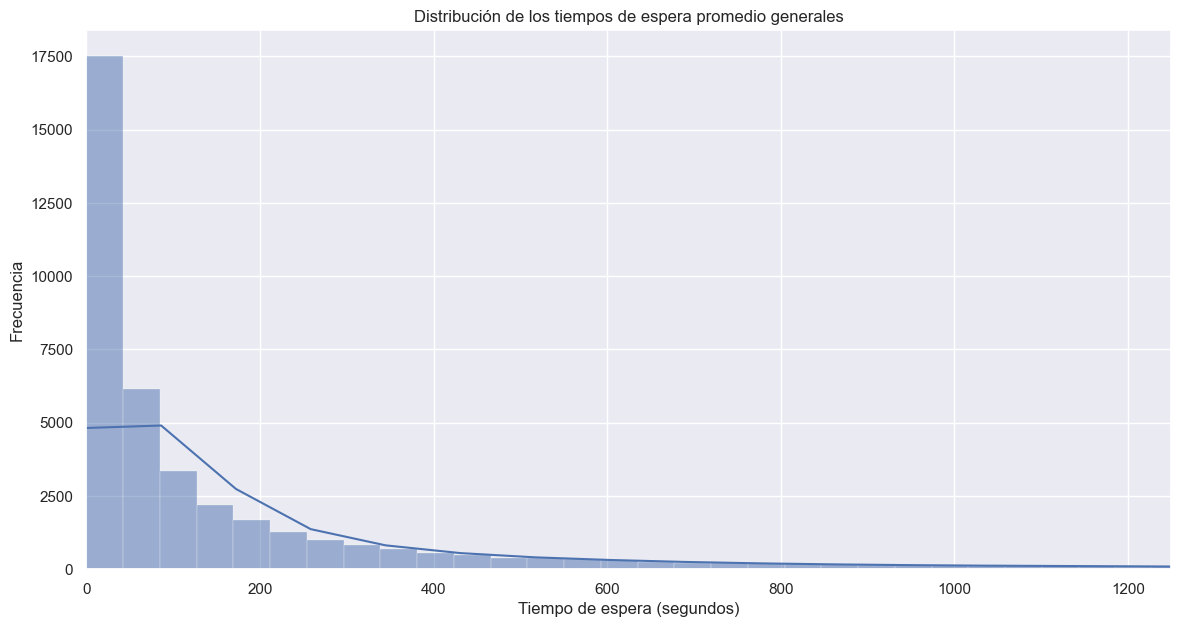

In [60]:
#### Calcular los tiempos de espera promedio por operador

# Agregar columna de tiempo de espera al df 'calls'
calls['wait_time'] = calls['total_call_duration'] - calls['call_duration']

# Graficar la distribución de los tiempos de espera promedio generales
plt.figure(figsize=(14, 7))
sns.histplot(
    data=calls,
    x='wait_time',
    kde=True
)

plt.xlim(0, 1250)  # Limitar el eje x para enfocarse en la mayoría de los datos
plt.title("Distribución de los tiempos de espera promedio generales")
plt.xlabel("Tiempo de espera (segundos)")
plt.ylabel("Frecuencia")

In [61]:
# Agrupar los datos por operador y calcular el tiempo de espera promedio
wait_time_per_operator = calls.groupby('operator_id')['wait_time'].mean().reset_index()

# Mostrar las estadísticas descriptivas de los tiempos de espera promedio por operador
round(wait_time_per_operator.describe(), 2)

,operator_id,wait_time
count,1092.00,1092.00
mean,925517.54,198.68
std,22854.53,399.63
min,879896.00,0.00
25%,906393.50,22.98
50%,925105.00,46.62
75%,944211.50,158.31
max,973286.00,4253.81


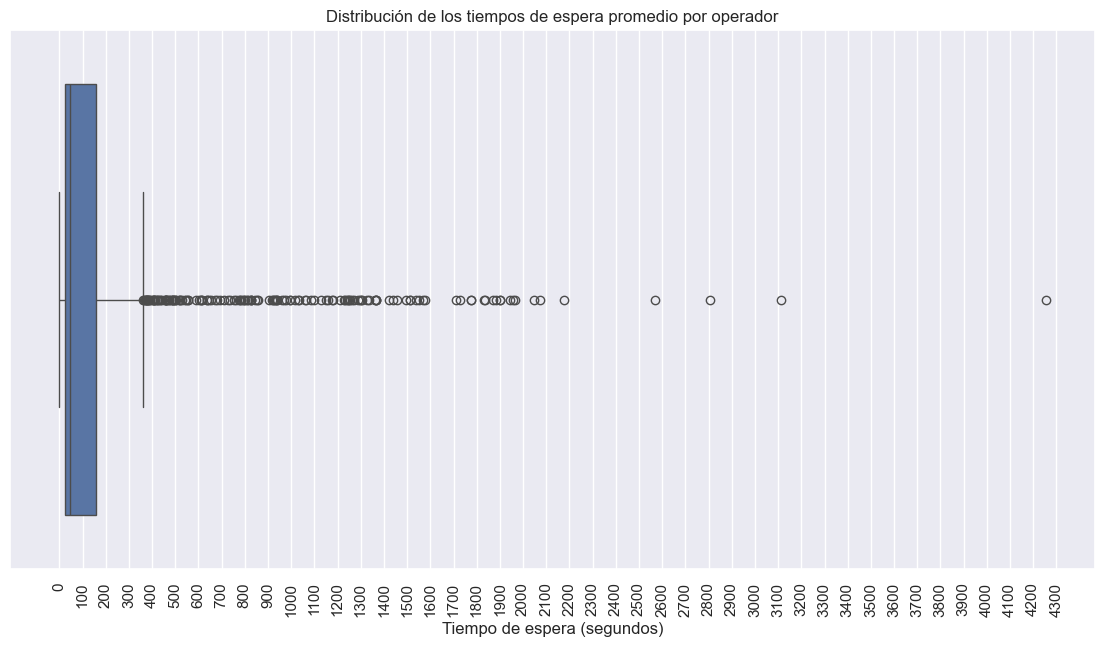

In [62]:
# Graficar la distribución de los tiempos de espera promedio por operador
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=wait_time_per_operator,
    x='wait_time',
)

plt.title("Distribución de los tiempos de espera promedio por operador")
plt.xlabel("Tiempo de espera (segundos)")
plt.xticks(np.arange(0, 4400, 100), rotation=90)  # Ajustar los ticks del eje x
plt.show()


Text(0.5, 1.0, 'Tiempos de espera promedio por operador')

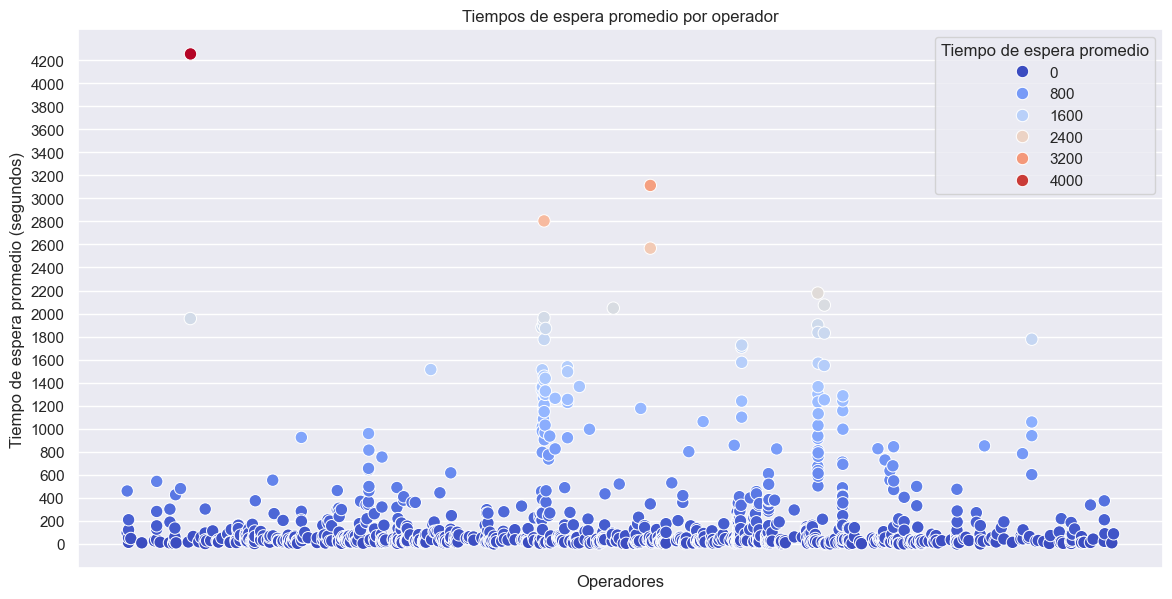

In [63]:
# Grafica de dispersión de los tiempos de espera promedio por operador
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=wait_time_per_operator,
    x='operator_id',
    y='wait_time',
    hue='wait_time',
    palette='coolwarm',
    s=80
)


plt.xticks([])
plt.yticks(np.arange(0, 4400, 200))  # Ajustar los ticks del eje y
plt.legend(title='Tiempo de espera promedio')
plt.ylabel("Tiempo de espera promedio (segundos)")
plt.xlabel("Operadores")
plt.title("Tiempos de espera promedio por operador")

In [64]:
# Calcular los percentiles de los tiempos de espera promedio por operador
percentiles_wait_time = np.percentile(wait_time_per_operator['wait_time'], [25, 50, 75, 80, 85, 90, 95, 99, 100])

# Mostrar los percentiles calculados
print("Los percentiles 25, 50, 75, 80, 85, 90, 95, 99 y 100 de los tiempos de espera promedio por operador son: \n",
      percentiles_wait_time.astype(int))

Los percentiles 25, 50, 75, 80, 85, 90, 95, 99 y 100 de los tiempos de espera promedio por operador son: 
 [  22   46  158  217  340  529 1091 1900 4253]


#### Observaciones sobre el tiempo de espera promedio por operador:

- La distribución general de los tiempos de espera muestra que la mayoría de los operadores mantienen tiempos de espera relativamente bajos, pero existen algunos casos con valores considerablemente altos, lo que indica la presencia de outliers o situaciones atípicas.
- El boxplot revela que el 75% de los operadores tienen un tiempo de espera promedio menor a aproximadamente 300 segundos, mientras que el resto presenta valores mucho más elevados, lo que sugiere diferencias importantes en la eficiencia entre operadores.
- El histograma y la gráfica de dispersión refuerzan la idea de que la mayoría de los operadores se agrupan en rangos bajos de tiempo de espera, pero hay un grupo reducido que destaca por tener tiempos de espera significativamente mayores.
- Estos resultados sugieren que, aunque la mayoría de los operadores gestionan adecuadamente el tiempo de espera de las llamadas, existe un subconjunto que podría requerir atención o capacitación adicional.

### 3.1.3 Radio de llamadas salientes  

In [65]:
# Calcular las llamadas tomadas por operador
operator_efficiency['taken_calls_rate'] = round(operator_efficiency['taken_calls'] / (
    operator_efficiency['taken_calls'] + operator_efficiency['missed_calls']), 2)

operator_efficiency

,operator_id,missed_calls,taken_calls,missed_call_rate,taken_calls_rate
0,879896,47,69,0.41,0.59
1,879898,89,137,0.39,0.61
2,880020,6,14,0.30,0.70
3,880022,29,41,0.41,0.59
4,880026,87,95,0.48,0.52
...,...,...,...,...,...
1087,972410,2,2,0.50,0.50
1088,972412,2,3,0.40,0.60
1089,972460,3,4,0.43,0.57
1090,973120,1,1,0.50,0.50


In [66]:
#### Analizar el número de llamadas salientes por operador

# Calcular el número de llamadas salientes por operador y día
outgoing_calls = calls[calls['direction'] == 'out'].groupby(['operator_id', 'date'])['calls_count'].sum().reset_index()
outgoing_calls = outgoing_calls.rename(columns={'calls_count': 'outgoing_calls_count'})

# Agregar el total de llamadas diarias por operador
daily_calls_per_operator = calls.groupby(['operator_id', 'date'])['calls_count'].sum().reset_index()

# Hacer un merge entre las llamadas salientes y las llamadas diarias por operador
calls_out_summary = pd.merge(
	daily_calls_per_operator,
	outgoing_calls,
	on=['operator_id', 'date'],
	how='left'
)

calls_out_summary['outgoing_calls_count'] = calls_out_summary['outgoing_calls_count'].fillna(0)

calls_out_summary['outgoing_calls_rate'] = round(
    calls_out_summary['outgoing_calls_count'] / calls_out_summary['calls_count'],
    2)
calls_out_summary['outgoing_calls_count'] = calls_out_summary['outgoing_calls_count'].astype(int)

calls_out_summary.sort_values(by='outgoing_calls_rate')

,operator_id,date,calls_count,outgoing_calls_count,outgoing_calls_rate
19626,973286.0,2019-11-28,2,0,0.0
9165,910540.0,2019-10-25,1,0,0.0
3177,893402.0,2019-11-13,8,0,0.0
9166,910540.0,2019-10-26,1,0,0.0
9167,910540.0,2019-10-27,1,0,0.0
...,...,...,...,...,...
2120,890422.0,2019-10-23,3,3,1.0
2119,890422.0,2019-10-22,1,1,1.0
2118,890422.0,2019-10-21,4,4,1.0
2152,890582.0,2019-11-08,2,2,1.0


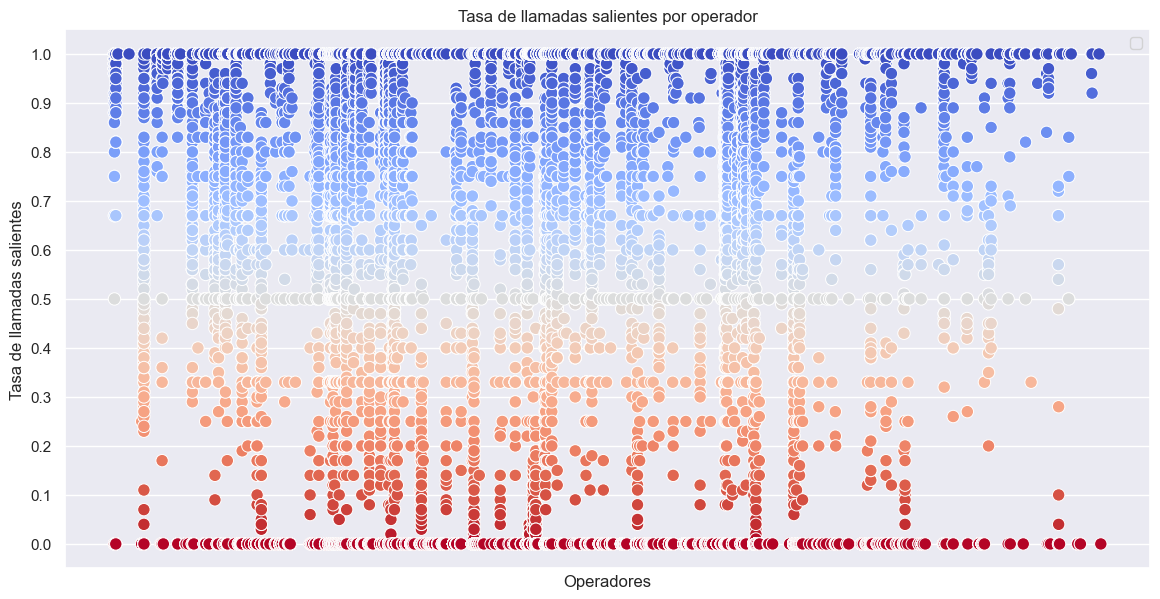

In [67]:
# Grafica la tasa de llamadas salientes por operador por día
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=calls_out_summary,
    x='operator_id',
    y='outgoing_calls_rate',
    hue='outgoing_calls_rate',
    palette='coolwarm_r',  # "_r" reverses the palette
    s=80
)
# Remover la leyenda, los xticks y agregar título
plt.legend([])
plt.xticks([])
plt.yticks(np.arange(0, 1.05, 0.1)) 
plt.title("Tasa de llamadas salientes por operador")
plt.ylabel("Tasa de llamadas salientes")
plt.xlabel("Operadores")
plt.show()

In [ ]:
#### Calcular los percentiles de la tasa de llamadas salientes por operador

# Obtener el promedio total de llamadas salientes por operador
total_outgoing_calls_per_operator = calls_out_summary.groupby('operator_id')[ 'outgoing_calls_rate'].mean().reset_index()


# Calcular los percentiles de la tasa de llamadas salientes por operador
percentiles_outgoing_calls = np.percentile(total_outgoing_calls_per_operator['outgoing_calls_rate'], [25, 30, 35, 40, 45, 50])

# Mostrar los percentiles de interés
print("Los percentiles 25, 30, 35, 40, 45 y 50 de los tiempos de espera promedio por operador son: \n",
      np.round(percentiles_outgoing_calls, 2))


Los percentiles 25, 30, 35, 40, 45 y 50 de los tiempos de espera promedio por operador son: 
 [0.2  0.37 0.5  0.6  0.69 0.76]


In [69]:
# Comprobar que no exista error en el cálculo de los percentiles de la tasa de llamadas salientes por operador

total_outgoing_calls_per_operator['outgoing_calls_rate'].describe()

count    1092.000000
mean        0.620297
std         0.398280
min         0.000000
25%         0.201146
50%         0.763155
75%         1.000000
max         1.000000
Name: outgoing_calls_rate, dtype: float64

## 3.2 Conclusiones sobre las métricas clave

- La tasa de llamadas perdidas por operador varía significativamente, con algunos operadores mostrando tasas muy altas.
- Los tiempos de espera promedio por operador también muestran una gran variabilidad, con algunos operadores teniendo tiempos de espera significativamente más altos.
- La tasa de llamadas salientes por operador muestra una densidad más alta en los porcentajes altos, lo que sugiere que muchos de los operadores están activos en la realización de llamadas salientes.
- Al ser la mayoría de las llamadas salientes, podemos deducir que la naturaleza del servicio es más proactiva desde los operadores, por lo que el porcentaje de llamadas salientes toma una relevancia especial en determinar la productividad y eficiencia.
- Estos hallazgos sugieren que hay oportunidades para mejorar la eficiencia operativa y la satisfacción del cliente al abordar las altas tasas de llamadas perdidas y los tiempos de espera prolongados para las llamadas entrantes.

**Recomendaciones de análisis:**

- Es necesario comprobar si existe una correlación entre la fecha de inicio del operador y su eficiencia. 
- Podemos también construir cohortes que arrojen luz sobre la existencia de una posible evolución o tendencia en cuestiones de eficiencia de los operadores a lo largo del tiempo.



## 3.3 Establecer los umbrales de ineficiencia 

En este punto, el establecer un umbral para definir la ineficiencia puede ser una tarea compleja debido a la falta de referencias respecto a la naturaleza del cliente con el cual trabajamos, así como sus números históricos y línea de negocio, lo cual nos daría la oportunidad de averiguar estándares en el sector y comprobar en dónde se ubican sus eficiencias para métricas similares.

De este modo, trabajaremos con únicamente la referencia dada en la descripción del proyecto así como con la información y observaciones que podemos extraer del dataset. Repasemos mencionado respecto a indicadores de ineficiencia:

    - Si un operador tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes.
    - Si se supone que un operador debe realizar llamadas salientes, tener un número reducido de ellas es una señal que indica ineficiencia.

Dicho esto, con las distribuciones observadas podemos definir nuestro esquema para determinar si un operador es ineficiente 

    - Basándonos en el percentil 85 de tiempo de espera: > 340 segundos 
    - Basándonos en los percentiles de llamadas perdidas entre 85 y 90 (en los cuales cae una gran cantidad de operadores) > 0.55
    - Considerando la alta tasa de llamadas salientes, y la naturaleza proactiva del servicio, establecemos el umbral de ineficiencia en en menos del 20% de llamadas salientes

Ahora bien, al haber 3 criterios para clasificar a un operador como ineficiente, debemos de considerar una segmentación. La siguiente clasificación es propuesta para lograr una mejor identificación de los grados de eficiencia, lo cual aporta información más integral en un sentido operativo, dándole más herramientas a supervisores y encargados para corregir y mejorar sus métricas.

- Si un asociado cae en solamente uno de cualquiera de los 3 criterios para considerar a un operador como ineficiente, se le colocará en la categoría de "opportunity_area".
- Si un asociado por otra parte cae en dos de los 3 criterios nombrados con anterioridad, se le debe considerar con una tendencia a la ineficiencia (lo cual requiere una mayo atención). Se le denomina a esta categoría "inefficiency_prone"
- Nuestra tercera categoría clasifica a aquellos asociados que son considerados como ineficientes en las tres áreas medibles. A éstos los tendremos por "inefficient_operators".

## 3.4 Segmentación y clasificación de operadores

In [70]:
#### Crear la lista de operadores ineficientes

# Enlistar los operadores ineficientes basados en los tiempos de espera promedio y convertirlos a tipo int
long_wait_operators = wait_time_per_operator[
    wait_time_per_operator['wait_time'] > 340]['operator_id'].tolist()
long_wait_operators = list(map(int, long_wait_operators))

# Enlistar los operadores ineficientes basados en la tasa de llamadas perdidas y convertirlos a tipo int
missed_calls_operators = operator_efficiency[
    operator_efficiency['missed_call_rate'] > 0.55]['operator_id'].tolist()
missed_calls_operators = list(map(int, missed_calls_operators))

# Enlistar los operadores ineficientes basados en la tasa de llamadas salientes y convertirlos a tipo int
low_outgoing_calls = total_outgoing_calls_per_operator[
    total_outgoing_calls_per_operator['outgoing_calls_rate'] < 0.2]['operator_id'].tolist()
low_outgoing_calls = list(map(int, low_outgoing_calls))

# Guardar el número de operadores eficientes
efficient_operators = len(set(calls['operator_id'].unique()) 
      - set(long_wait_operators) 
      - set(missed_calls_operators) 
      - set(low_outgoing_calls))

### 3.4.1 Graficar los operadores ineficientes

([], [])

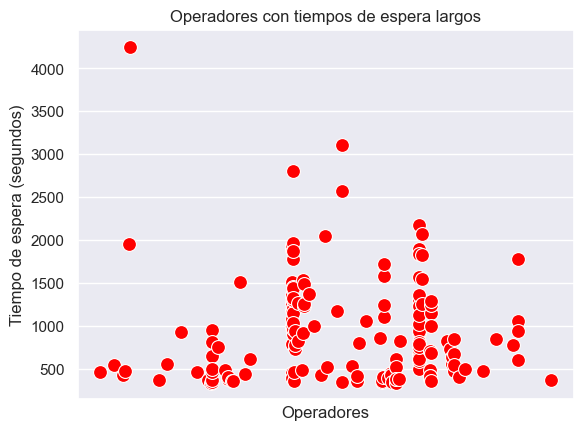

In [ ]:
# Graficar los operadores con tiempos de espera largos
sns.scatterplot(
    data=wait_time_per_operator[wait_time_per_operator['operator_id'].isin(long_wait_operators)],
    x='operator_id',
    y='wait_time',
    color='red',
    s=100
)

plt.title("Operadores con tiempos de espera largos")
plt.xlabel("Operadores")
plt.ylabel("Tiempo de espera (segundos)")
plt.xticks([])

([], [])

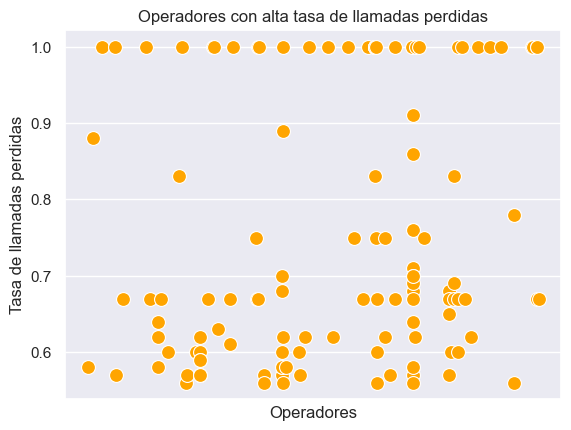

In [72]:
# Graficar los operadores con tasa de llamadas perdidas alta

sns.scatterplot(
    data=operator_efficiency[operator_efficiency['operator_id'].isin(missed_calls_operators)],
    x='operator_id',
    y='missed_call_rate',
    color='orange',
    s=100
)

plt.title("Operadores con alta tasa de llamadas perdidas")
plt.xlabel("Operadores")
plt.ylabel("Tasa de llamadas perdidas")
plt.xticks([])


([], [])

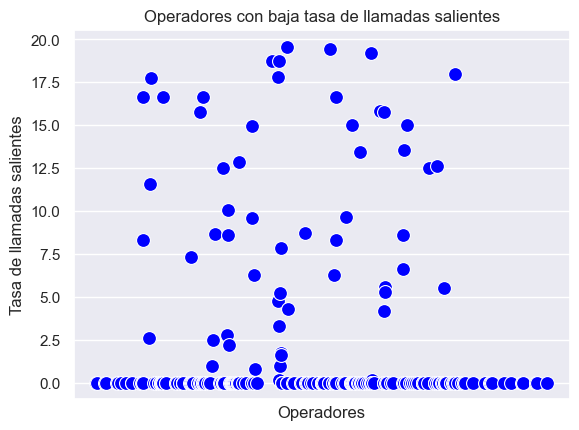

In [73]:
# Graficar los operadores con tasa de llamadas salientes baja

sns.scatterplot(
    data=total_outgoing_calls_per_operator[total_outgoing_calls_per_operator['operator_id'].isin(low_outgoing_calls)],
    x='operator_id',
    y=total_outgoing_calls_per_operator[total_outgoing_calls_per_operator['operator_id'].isin(low_outgoing_calls)]['outgoing_calls_rate'] * 100,
    color='blue',
    s=100
)

plt.title("Operadores con baja tasa de llamadas salientes")
plt.xlabel("Operadores")
plt.ylabel("Tasa de llamadas salientes")
plt.xticks([])

In [75]:
#### Clasificar a los operadores ineficientes

# Crear listas para las distintas categorías de eficiencia
opportunity_area = []
inefficiency_prone = []
inefficient_operators = []
efficient_operators = []

# Evaluar cada operador según su presencia en los criterios
for operator in calls['operator_id'].unique():
    criteria_hit = sum([
        operator in long_wait_operators,
        operator in missed_calls_operators,
        operator in low_outgoing_calls
    ])
    
    if criteria_hit == 1:
        opportunity_area.append(operator)
    elif criteria_hit == 2:
        inefficiency_prone.append(operator)
    elif criteria_hit == 3:
        inefficient_operators.append(operator)
    else:
        efficient_operators.append(operator)


# Convertir las listas a tipo int 
opportunity_area = list(map(int, opportunity_area))
inefficiency_prone = list(map(int, inefficiency_prone))
inefficient_operators = list(map(int, inefficient_operators))
efficient_operators = list(map(int, efficient_operators))

In [76]:
# Mostrar el conteo de operadores ineficientes en cada área (área de oportunidad, tendencia a la ineficiencia, ineficientes y eficientes)

print("Conteo de operadores ineficientes en cada área:")
print("Operadores con tiempos de espera largos:", len(long_wait_operators))
print("Operadores con tasa de llamadas perdidas alta:", len(missed_calls_operators))
print("Operadores con tasa de llamadas salientes baja:", len(low_outgoing_calls))
print("Operadores eficientes:", len(efficient_operators))


# Mostrar las listas de operadores ineficientes/eficientes

print("\n Clasificación de operadores:")
print(f"- Área de oportunidad: {len(opportunity_area)}")
print(f"- Tendencia a la ineficiencia: {len(inefficiency_prone)}")
print(f"- Ineficientes: {len(inefficient_operators)}")
print(f"- Eficientes: {len(efficient_operators)}")

Conteo de operadores ineficientes en cada área:
Operadores con tiempos de espera largos: 165
Operadores con tasa de llamadas perdidas alta: 124
Operadores con tasa de llamadas salientes baja: 268
Operadores eficientes: 588

 Clasificación de operadores:
- Área de oportunidad: 451
- Tendencia a la ineficiencia: 53
- Ineficientes: 0
- Eficientes: 588


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10656\2346920998.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0.5, 1.0, 'Clasificación de los operadores ineficientes/eficientes')

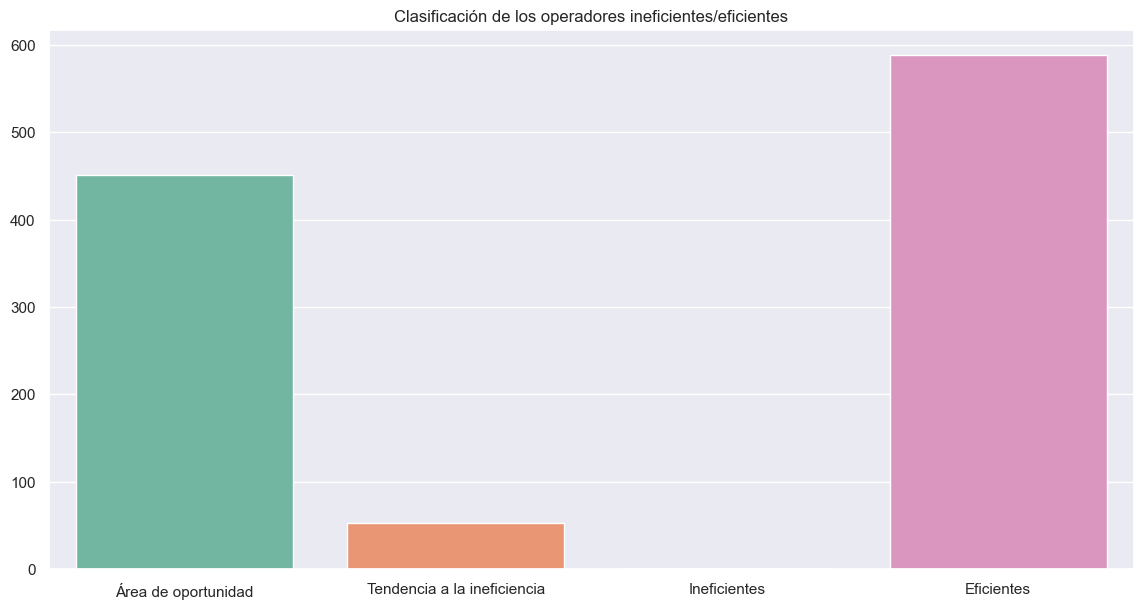

In [77]:
# Graficar la clasificación de los operadores ineficientes/eficientes

plt.figure(figsize=(14, 7))
sns.barplot(
    x=['Área de oportunidad', 'Tendencia a la ineficiencia', 'Ineficientes', 'Eficientes'],
    y=[len(opportunity_area), len(inefficiency_prone), len(inefficient_operators), len(efficient_operators)],
    palette='Set2'
)

plt.title("Clasificación de los operadores ineficientes/eficientes")

### 3.4.2 Conclusiones sobre la clasificación de operadores ineficientes y su distribución:

Los resultados de la segmentación anterior, nos muestra que ninguno de los operadores es completamente ineficiente. Más de un 50% del total puede considerarse "eficiente" o por lo menos no caen en ninguno de los criterios para ser considerados ineficientes. 

Tenemos ahora la lista de aquellos quienes tienen problemas con alguno de los criterios de eficiencia (451) y los que se encuentran debajo de las expectativas en dos de ellos(53). 

El siguiente paso en nuestro análisis será comprobar si existe una correlación entre esta ineficiencia y la fecha de inicio (antiguedad) del asociado en cuestión. 

# 4. Análisis de relaciones entre variables

Para comenzar a correlacionar la eficiencia de los asociados con su fecha de inicio, tendremos que realizar un análisis de cohortes y medir nuevamente la eficiencia para los distintos grupos. Entonces, podremos determinar si la hipótesis presentada tiene algún tipo de sustento. 

## 4.1 Análisis de cohortes 

In [78]:
#### Agregar una columnas adicionales de clasificación y cohorte al df 'calls'

# Agregar una columna de clasificación de eficiencia de operadores al df 'calls
calls['operator_classification'] = 'Eficiente'
calls.loc[calls['operator_id'].isin(opportunity_area), 'operator_classification'] = 'Área de Oportunidad'
calls.loc[calls['operator_id'].isin(inefficiency_prone), 'operator_classification'] = 'Tendencia a la Ineficiencia'
calls.loc[calls['operator_id'].isin(inefficient_operators), 'operator_classification'] = 'Ineficiente'

# Encontrar la fecha de inicio del operador al df 'calls'
operator_start_dates = calls.groupby('operator_id')['date'].min().reset_index()
operator_start_dates = operator_start_dates.rename(columns={'date': 'operator_start_date'})

# Agregar la fecha de inicio del operador al df 'calls'
calls = pd.merge(calls, operator_start_dates, on='operator_id', how='left')

# Convertir la columna 'operator_start_date' a tipo date
calls['operator_start_date'] = pd.to_datetime(calls['operator_start_date']).dt.date

# Mostrar las columnas del df 'calls' para verificar los cambios
print(calls.columns)

Index(['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'call_duration', 'total_call_duration',
       'wait_time', 'operator_classification', 'operator_start_date'],
      dtype='object')


Text(0, 0.5, 'Frecuencia')

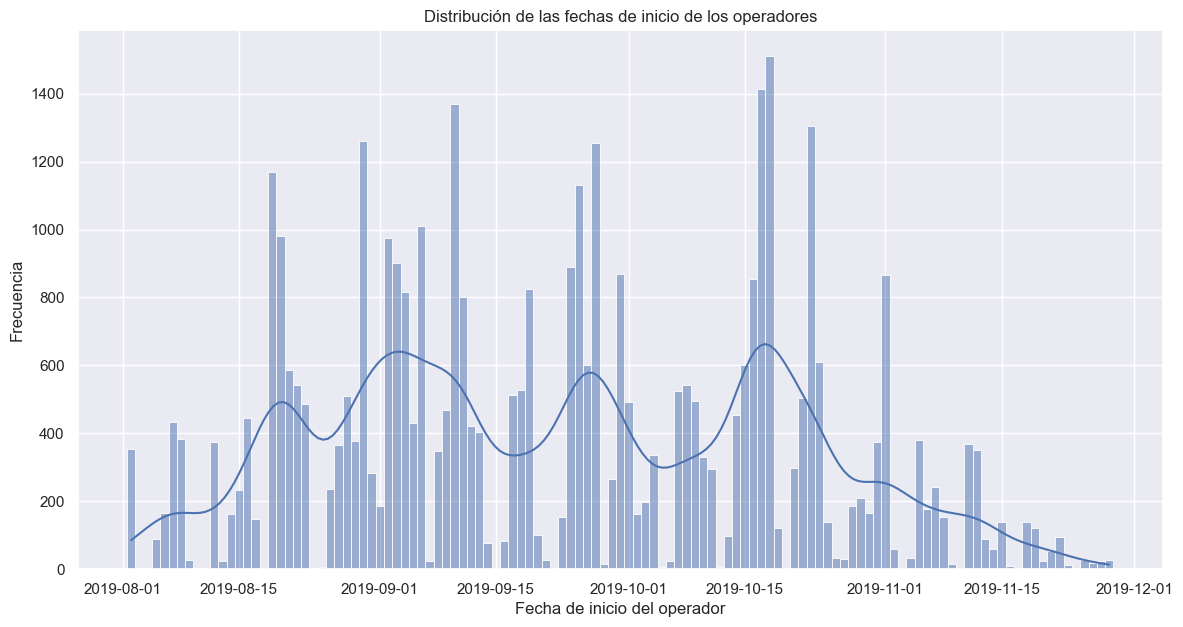

In [79]:
#### Analizar la distribución de las fechas de inicio de los operadores

# Crear gráfico de barras para la distribución de las fechas de inicio de los operadores
plt.figure(figsize=(14, 7))
sns.histplot(
    data=calls,
    x='operator_start_date',
    kde=True
)
plt.title("Distribución de las fechas de inicio de los operadores")
plt.xlabel("Fecha de inicio del operador")
plt.ylabel("Frecuencia")

In [80]:
# Contar el número de fechas de inicio de operadores
print("\n Número de fechas de inicio de operadores: \n",
      calls['operator_start_date'].nunique())


 Número de fechas de inicio de operadores: 
 109


#### Comentario:
Al haber 109 fechas de inicio de operadores, crearemos cohortes con períodos de 14 días para analizar la evolución de los operadores a lo largo del tiempo, lo cual se dividirá en 8 cohortes aproximadamente y a su vez esto va a "cuadrar" cada grupo con la estacionalidad observada de una semana y también facilitará la toma de mediciones de eficiencia cada semana para un mejor seguimiento de la evolución del desempeño.


In [81]:
#### Crear cohortes de 14 días para el análisis:

# Copiar el df para su manipulación
operator_cohorts = calls.copy()

# Convertir columna 'date' a formato fecha
operator_cohorts['date'] = pd.to_datetime(operator_cohorts['date']).dt.date

# Convertir columna 'operator_id' a int
operator_cohorts['operator_id'] = operator_cohorts['operator_id'].astype(int)

# Definir fecha de inicio
start_date = operator_cohorts['operator_start_date'].min()

# Calculate the timedelta in days between operator_start_date and start_date
operator_cohorts['cohort'] = (operator_cohorts['operator_start_date'] - start_date).apply(lambda x: x.days)

# Aumentar en 1 el valor en la columna timedelta para poder hacer la división de 12 días
operator_cohorts['cohort'] = operator_cohorts['cohort'] + 1

# Hacer la división entre 14 para tener nuestras cohortes organizadas
operator_cohorts['cohort'] = (operator_cohorts['cohort'] // 14).astype(int)

# Agregar una columna de semana para organizar el progreso de las cohortes
operator_cohorts['week'] = operator_cohorts['date'].apply(lambda x: (x - start_date).days // 7)

## 4.2 Evolución de métricas por cohorte y semana

In [82]:
#### Agrupar los datos de columna 'direction' por cohorte y semana

# Convertir la columna 'direction' a binario
operator_cohorts['direction'] = operator_cohorts[
    'direction'].map({'in': 0, 'out': 1})

# Convertir la coumna 'is_missed_call' a tipo binario
operator_cohorts['is_missed_call'] = operator_cohorts[
    'is_missed_call'].map({True: 0, False: 1})

# Crear agrupación para medir el promedio de dirección de llamadas por operador y cohorte
operator_cohort_direction_avg = operator_cohorts.groupby(
    ['cohort', 'week'])['direction'].mean().reset_index()  

# Crear una tabla pivote para analizar la evolución de las cohortes con el paso de las semanas en llamadas salientes
operator_cohorts_direction_pivot = operator_cohort_direction_avg.pivot_table(
    index='cohort',
    columns='week',
    values='direction',
    aggfunc='mean'
)

In [ ]:
#### Agrupar los datos de columna 'is_missed_call' por cohorte y semana

# Crear agrupación para medir el promedio de llamadas perdidas por operador y cohorte
operator_cohort_missed_avg = operator_cohorts.groupby(
    ['cohort', 'week'])['is_missed_call'].mean().reset_index()

# Crear una tabla pivote para analizar la evolución de las cohortes con el paso de las semanas en llamadas perdidas
operator_cohorts_missed_pivot = operator_cohort_missed_avg.pivot_table(
    index='cohort',
    columns='week',
    values='is_missed_call',
    aggfunc='mean')

In [84]:
#### Agrupar tiempos de espera promedio por cohorte y semana

# Crear agrupación para medir el promedio de tiempos de espera por semana y cohorte
operator_cohort_wait_avg = operator_cohorts.groupby(
    ['cohort', 'week'])['wait_time'].mean().reset_index()

# Crear una tabla pivote para analizar la evolución de las cohortes con el paso de las semanas en tiempos de espera
operator_cohorts_wait_pivot = operator_cohort_wait_avg.pivot_table(
    index='cohort',
    columns='week',
    values='wait_time',
    aggfunc='mean'
)

Text(142.25, 0.5, 'Cohorte')

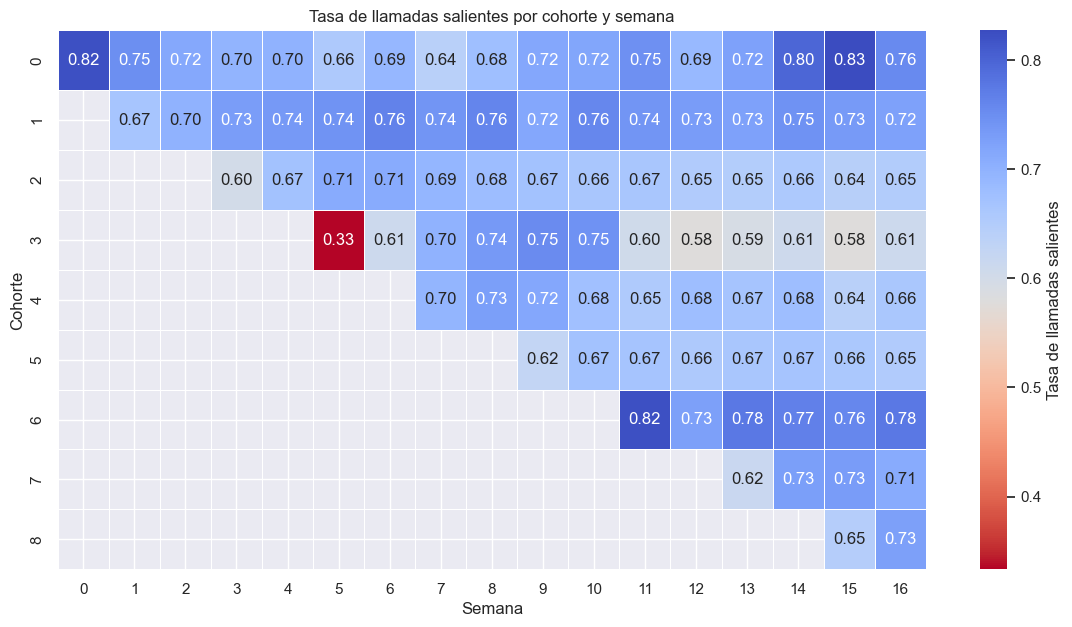

In [85]:
#### Crear heatmaps para visualizar las cohortes y semanas vs las métricas clave

# Crear un heatmap para la tasa de llamadas salientes por cohorte y semana
plt.figure(figsize=(14,7))
sns.heatmap(
    operator_cohorts_direction_pivot,
    annot=True,
    fmt=".2f",
    cmap='coolwarm_r',
    cbar_kws={'label': 'Tasa de llamadas salientes'},
    linewidths=0.5
)

plt.title("Tasa de llamadas salientes por cohorte y semana")
plt.xlabel("Semana")
plt.ylabel("Cohorte")

Text(142.25, 0.5, 'Cohorte')

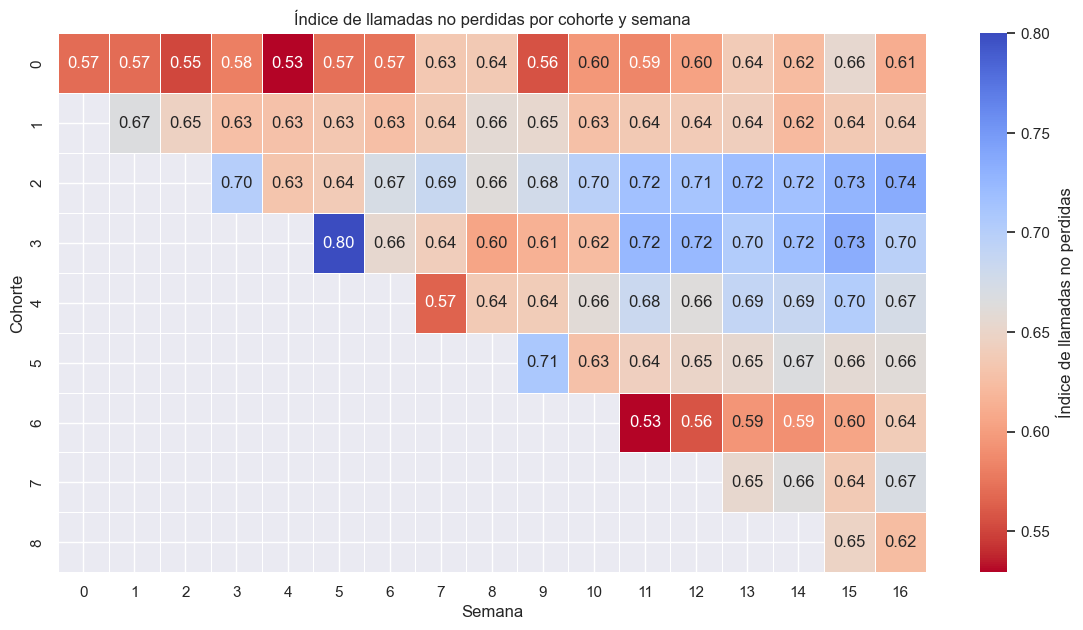

In [86]:
### Graficar la evolución de las cohortes con el paso de las semanas en llamadas perdidas
plt.figure(figsize=(14, 7))
sns.heatmap(
    operator_cohorts_missed_pivot,
    annot=True,
    fmt=".2f",
    cmap='coolwarm_r',
    cbar_kws={'label': 'Índice de llamadas no perdidas'},
    linewidths=0.5
)

plt.title("Índice de llamadas no perdidas por cohorte y semana")
plt.xlabel("Semana")
plt.ylabel("Cohorte")

Text(142.25, 0.5, 'Cohorte')

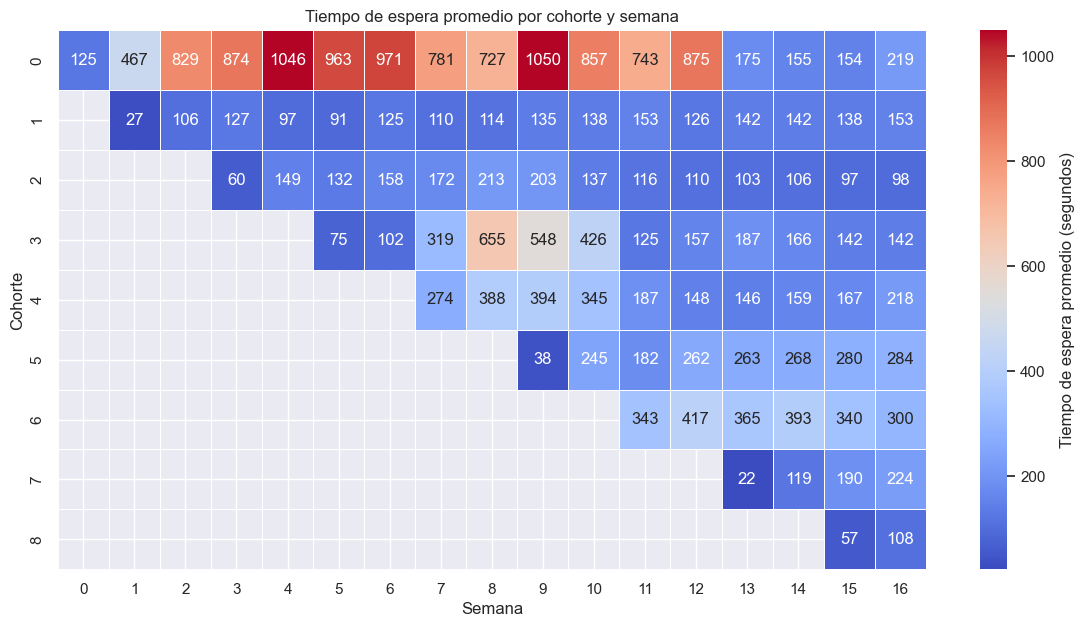

In [87]:
# Crear un heatmap para la tasa de tiempos de espera por cohorte y semana
plt.figure(figsize=(14, 7))
sns.heatmap(
    operator_cohorts_wait_pivot,
    annot=True,
    fmt=".0f",
    cmap='coolwarm',
    cbar_kws={'label': 'Tiempo de espera promedio (segundos)'},
    linewidths=0.5
)

plt.title("Tiempo de espera promedio por cohorte y semana")
plt.xlabel("Semana")
plt.ylabel("Cohorte")

#### Observaciones de las métricas clave por cohorte:
1. La tasa de llamadas salientes por cohorte y semana muestra una tendencia a la mejora leve en la mayoría de las cohortes, lo que indica que los operadores normalmente mejoran en la gestión de llamadas salientes a lo largo del tiempo.
2. El índice de llamadas no perdidas por cohorte y semana no muestra una tendencia clara, lo que sugiere que la tasa de llamadas perdidas puede ser inconsistente entre las cohortes y las semanas.
3. El tiempo de espera promedio por cohorte y semana muestra una tendencia al desmejoramiento en la mayoría de las cohortes, lo que es un claro indicador de que esta se trata de una métrica la cual no es debidamente gestionada y atendida por parte de la gerencia operativa.

En general, podemos concluir que se observa una diferencia sustancial en la eficiencia de distintas cohortes de operadores, lo que sugiere que se trata no de diferencias aleatorias, sino de fallas en la gestión interna (capacitación, seguimiento, supervisión) de los grupos de asociados. Aunque no contamos con información de este manejo operativo de los empleados, tenemos los suficientes elementos para probar estadísticamente si existe una diferencia significativa en su desempeño dependiendo de su cohorte.

## 4.3 Matriz de correlación entre métricas clave

           direction    missed  wait_time
direction   1.000000 -0.685757   0.156701
missed     -0.685757  1.000000  -0.632533
wait_time   0.156701 -0.632533   1.000000


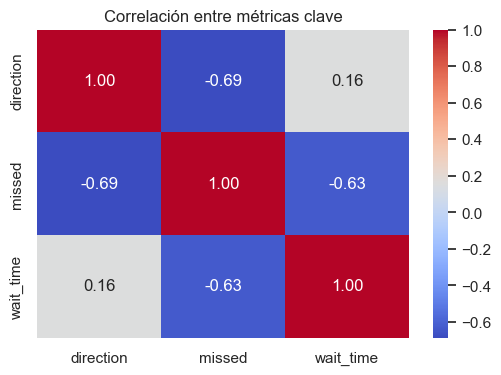

In [88]:
#### Generar matriz de correlación para las métricas clave

# Calcular la matriz de correlación

# Unir las tres tablas pivote en un solo DataFrame
metrics_combined = pd.DataFrame({
    'direction': operator_cohorts_direction_pivot.stack(),
    'missed': operator_cohorts_missed_pivot.stack(),
    'wait_time': operator_cohorts_wait_pivot.stack()
}).reset_index()

# Calcular la matriz de correlación
correlation_matrix = metrics_combined[['direction', 'missed', 'wait_time']].corr()

print(correlation_matrix)

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación entre métricas clave')
plt.show()

#### Observaciones sobre la correlación entre las métricas:

1. La tasa de llamadas salientes y el índice de llamadas no perdidas tienen una correlación positiva moderada (-0.69), lo que sugiere que a medida que aumenta la tasa de llamadas salientes, también tiende a aumentar el índice de llamadas no perdidas.
2. La tasa de llamadas salientes y el tiempo de espera promedio tienen una correlación casi neutral (0.16), lo que indica que no existe una influencia entre estas dos métricas.
3. El índice de llamadas no perdidas y el tiempo de espera promedio tienen una correlación negativa moderada (-0.63), lo que sugiere que a medida que aumenta el índice de llamadas no perdidas, el tiempo de espera promedio tiende a disminuir.
4. En general, podemos decir que las 3 las métricas clave están ligeramente interrelacionadas, lo que indica que mejorar una de estas puede tener un impacto positivo en las otras (Mejorar en el tiempo de espera debe por tanto ser beneficioso para el número de llamadas perdidas y esto a la vez mejorar el índice de llamadas salientes al estar estas dos últimas ligadas) 


# 5. Hipótesis y pruebas estadísticas

## 5.1 Elaboración de hipótesis:

Basándonos en las diversas observaciones realizadas hasta este momento, podemos proceder a formular nuestras hipótesis y establecer los parámetros necesarios para hacer las pruebas estadísticas necesarias. 

    **Hipótesis:** La eficiencia operativa varía por cohorte de inicio.

    **Hipótesis nula:** No existen diferencias en las métricas clave entre las cohortes.

Justificación: El análisis por cohortes muestra diferencias en las métricas clave (tasa de llamadas perdidas, llamadas salientes y tiempos de espera) entre grupos de operadores que iniciaron en diferentes periodos, lo que puede estar relacionado con cambios en capacitación, procesos o condiciones de trabajo.

## 5.2 Selección y justificación de pruebas estadísticas:
La prueba estadística más adecuada para comprobar la hipótesis planteada ("La eficiencia operativa varía por cohorte de inicio") es ANOVA debido a la naturaleza de la comprobación necesaria: tenemos más de 3 grupos independientes y queremos saber si existe diferencia de su desempeño en diferentes métricas.

**Justificación:**

¿Qué es una prueba ANOVA?
Significa Análisis de la Varianza, una prueba estadística utilizada para comparar las medias de tres o más grupos. Analiza la varianza dentro del grupo y entre grupos. El objetivo principal es evaluar si la varianza observada entre las medias de los grupos es más significativa que dentro de los grupos. Si la varianza observada entre las medias de los grupos es significativa, sugiere que las diferencias son significativas.

Matemáticamente, el ANOVA descompone la variabilidad total de los datos en dos componentes:

> Variabilidad dentro del grupo: Variabilidad causada por las diferencias dentro de los grupos individuales, que refleja fluctuaciones aleatorias.

> Variabilidad entre grupos: Variabilidad causada por las diferencias entre las medias de los distintos grupos.

![Estadístico F para calcular el ANOVA](https://media.datacamp.com/cms/google/ad_4nxeor3cucgyesa4ay36kor-w07ijzqbcezzvhxir2mcyhmpeu1eh2bpxod1of_u4dhneqwbdgczit91kq_or1it_jqwxelpjfmbmrk51dl0ad6ufkn28pyf0jayin0_ntjwioz0zobng2gkqx_rgnvizqxg.png)

**Fuentes:** 
https://www.datacamp.com/es/tutorial/anova-test
https://www.geeksforgeeks.org/python/how-to-perform-a-one-way-anova-in-python/

## 5.3 Pruebas de normalidad y varianza de las muestras (Como preparación para la prueba ANOVA)

En este apartado, comprobaremos que los datos de nuestros grupos cumplen con los requisitos (asunciones) para realizar una prueba ANOVA los cuales son:
- Independencia: Las muestras de cada grupo deben ser independientes.
- Normalidad: Los datos de cada grupo deben seguir una distribución aproximadamente normal (Prueba Shapiro-Wilk.)
- Homogeneidad de varianzas (Homocedasticidad): Las varianzas de los datos deben ser aproximadamente iguales en todos los grupos. (Prueba Levene)

Estas suposiciones nos obligan a hacer las comprobaciones necesarias previas a realizar ANOVA, requiriendo en sí pruebas de normalidad y de varianza que asumimos de antemano para poder asegurar que los resultados de la misma son confiables.

    Para todas las pruebas a realizar (Shapiro-Wilk, Levene y Anova) nuestro valor alpha será de 0.05

In [112]:
#### Extraer las muestras para calcular la varianza interna y entre cohortes 

### Al haber 9 cohortes, y al estar evaluando el progreso de las cohortes a lo largo de las semanas, usaremos solamente las cohortes
### que tengan al menos 8 semanas de datos para evitar cohortes con pocos datos que puedan afectar el análisis y también usaremos esas
### 8 semanas para tener el mismo número de semanas en cada cohorte.

 
####  Acotar las cohortes a las que tienen al menos 8 semanas de datos y seccionarlas para el análisis (en variables)

# Obtener los valores de 'direction' para cada cohorte desde metrics_combined
cohort_0_direct = metrics_combined[(metrics_combined['cohort'] == 0)]['direction'].values[:8]
cohort_1_direct = metrics_combined[(metrics_combined['cohort'] == 1)]['direction'].values[:8]
cohort_2_direct = metrics_combined[(metrics_combined['cohort'] == 2)]['direction'].values[:8]
cohort_3_direct = metrics_combined[(metrics_combined['cohort'] == 3)]['direction'].values[:8]
cohort_4_direct = metrics_combined[(metrics_combined['cohort'] == 4)]['direction'].values[:8]
cohort_5_direct = metrics_combined[(metrics_combined['cohort'] == 5)]['direction'].values[:8]

# Obtener los valores de 'missed' para cada cohorte desde metrics_combined
cohort_0_missed = metrics_combined[(metrics_combined['cohort'] == 0)]['missed'].values[:8]
cohort_1_missed = metrics_combined[(metrics_combined['cohort'] == 1)]['missed'].values[:8]
cohort_2_missed = metrics_combined[(metrics_combined['cohort'] == 2)]['missed'].values[:8]
cohort_3_missed = metrics_combined[(metrics_combined['cohort'] == 3)]['missed'].values[:8]
cohort_4_missed = metrics_combined[(metrics_combined['cohort'] == 4)]['missed'].values[:8]
cohort_5_missed = metrics_combined[(metrics_combined['cohort'] == 5)]['missed'].values[:8]

# Obtener los valores de 'wait_time' para cada cohorte desde metrics_combined
cohort_0_wait = metrics_combined[(metrics_combined['cohort'] == 0)]['wait_time'].values[:8]
cohort_1_wait = metrics_combined[(metrics_combined['cohort'] == 1)]['wait_time'].values[:8]
cohort_2_wait = metrics_combined[(metrics_combined['cohort'] == 2)]['wait_time'].values[:8]
cohort_3_wait = metrics_combined[(metrics_combined['cohort'] == 3)]['wait_time'].values[:8]
cohort_4_wait = metrics_combined[(metrics_combined['cohort'] == 4)]['wait_time'].values[:8]
cohort_5_wait = metrics_combined[(metrics_combined['cohort'] == 5)]['wait_time'].values[:8]

# Crear una lista de grupos para cada métrica

direction_groups = [ # Dirección de llamadas
    cohort_0_direct, 
    cohort_1_direct, 
    cohort_2_direct, 
    cohort_3_direct, 
    cohort_4_direct, 
    cohort_5_direct
]

missed_groups = [ # Llamadas perdidas
    cohort_0_missed, 
    cohort_1_missed, 
    cohort_2_missed, 
    cohort_3_missed, 
    cohort_4_missed, 
    cohort_5_missed
]

wait_groups = [ # Tiempos de espera
    cohort_0_wait, 
    cohort_1_wait, 
    cohort_2_wait, 
    cohort_3_wait, 
    cohort_4_wait, 
    cohort_5_wait
]

In [113]:
#### Realizar prueba LEVENE estadística para comprobar la igualdad de varianzas entre los grupos

# Prueba de Levene para la dirección de llamadas
levene_direction = levene(*direction_groups)
print("Prueba de Levene para la dirección de llamadas: ",
    "\n estadístico =", levene_direction.statistic,
    "\n valor p =", levene_direction.pvalue)

print("\n " \
"La prueba de Levene para la dirección de llamadas indica que las varianzas no son iguales (p < 0.05)"
"\n Por lo tanto, no podemos asumir homogeneidad de varianzas para la prueba ANOVA.")

Prueba de Levene para la dirección de llamadas:  
 estadístico = 4.606644794385051 
 valor p = 0.0019330372523165657

 La prueba de Levene para la dirección de llamadas indica que las varianzas no son iguales (p < 0.05)
 Por lo tanto, no podemos asumir homogeneidad de varianzas para la prueba ANOVA.


In [115]:
# Prueba de Levene para las llamadas perdidas
levene_missed = levene(*missed_groups)
print("Prueba de Levene para las llamadas perdidas: ",
    "\n estadístico =", levene_missed.statistic,
    "\n valor p =", levene_missed.pvalue)

print("\n La prueba de Levene para las llamadas perdidas indica que las varianzas no son iguales (p < 0.05)"
      "\n Por lo tanto, no podemos asumir homogeneidad de varianzas para la prueba ANOVA.")

Prueba de Levene para las llamadas perdidas:  
 estadístico = 2.475808271548697 
 valor p = 0.04713493249350406

 La prueba de Levene para las llamadas perdidas indica que las varianzas no son iguales (p < 0.05)
 Por lo tanto, no podemos asumir homogeneidad de varianzas para la prueba ANOVA.


In [116]:
# Prueba de levene para los tiempos de espera
levene_wait = levene(*wait_groups)
print("Prueba de Levene para los tiempos de espera: ",
    "\n estadístico =", levene_wait.statistic,
    "\n valor p =", levene_wait.pvalue)

print("\n La prueba de Levene para los tiempos de espera indica que las varianzas son iguales (p > 0.05)"
      "\n Por lo tanto, podemos asumir homogeneidad de varianzas para la prueba ANOVA.")

Prueba de Levene para los tiempos de espera:  
 estadístico = 3.830615801672427 
 valor p = 0.005991843283094178

 La prueba de Levene para los tiempos de espera indica que las varianzas son iguales (p > 0.05)
 Por lo tanto, podemos asumir homogeneidad de varianzas para la prueba ANOVA.


### 5.3.1 Conclusiones sobre la prueba LEVENE estadística para comprobar la igualdad de varianzas entre los grupos

    Dos de nuestros grupos de métricas no cumplen con los requerimientos de normalidad de acuerdo con los resultados de la prueba Levene, por lo tanto no será posible evaluar la diferencia estadística entre cohortes para ellos. Será necesario aplicar la prueba Welch ANOVA, -esto solamente si es que se encuentra normalidad en los grupos de datos-.

In [117]:
#### Realizar la prueba shapiro-wilk para comprobar la normalidad de los datos

# Crear una función para realizar la prueba de Shapiro-Wilk en cada grupo
def shapiro_test(groups):
    for i, group in enumerate(groups):
        stat, p = shapiro(group)
        print(f"Cohorte {i}: estadístico = {stat:.4f}, p-valor = {p:.4f}")
        if p < 0.05:
            print("  → La distribución de la cohorte no es normal")
        else:
            print("  → La distribución de la cohorte es normal")


# Prueba de Shapiro-Wilk para la dirección de llamadas
print("Prueba de Shapiro-Wilk para la dirección de llamadas: \n")
shapiro_test(direction_groups)

Prueba de Shapiro-Wilk para la dirección de llamadas: 

Cohorte 0: estadístico = 0.9154, p-valor = 0.3934
  → La distribución de la cohorte es normal
Cohorte 1: estadístico = 0.8877, p-valor = 0.2227
  → La distribución de la cohorte es normal
Cohorte 2: estadístico = 0.8503, p-valor = 0.0959
  → La distribución de la cohorte es normal
Cohorte 3: estadístico = 0.8246, p-valor = 0.0521
  → La distribución de la cohorte es normal
Cohorte 4: estadístico = 0.9389, p-valor = 0.5998
  → La distribución de la cohorte es normal
Cohorte 5: estadístico = 0.8191, p-valor = 0.0457
  → La distribución de la cohorte no es normal


In [106]:
# Prueba Shapiro-Wilk para las llamadas perdidas
print("Prueba Shapiro-Wilk para las llamadas perdidas: \n")
shapiro_test(missed_groups)

Prueba Shapiro-Wilk para las llamadas perdidas: 

Cohorte 0: estadístico = 0.8718, p-valor = 0.1570
  → La distribución de la cohorte es normal
Cohorte 1: estadístico = 0.8744, p-valor = 0.1664
  → La distribución de la cohorte es normal
Cohorte 2: estadístico = 0.9255, p-valor = 0.4757
  → La distribución de la cohorte es normal
Cohorte 3: estadístico = 0.8833, p-valor = 0.2027
  → La distribución de la cohorte es normal
Cohorte 4: estadístico = 0.8349, p-valor = 0.0668
  → La distribución de la cohorte es normal
Cohorte 5: estadístico = 0.8895, p-valor = 0.2315
  → La distribución de la cohorte es normal


In [107]:
# Prueba de Shapiro-Wilk para los tiempos de espera
print("Prueba Shapiro-Wilk para los tiempos de espera: \n")
shapiro_test(wait_groups)

Prueba Shapiro-Wilk para los tiempos de espera: 

Cohorte 0: estadístico = 0.8362, p-valor = 0.0688
  → La distribución de la cohorte es normal
Cohorte 1: estadístico = 0.7840, p-valor = 0.0193
  → La distribución de la cohorte no es normal
Cohorte 2: estadístico = 0.9329, p-valor = 0.5431
  → La distribución de la cohorte es normal
Cohorte 3: estadístico = 0.8902, p-valor = 0.2352
  → La distribución de la cohorte es normal
Cohorte 4: estadístico = 0.8411, p-valor = 0.0773
  → La distribución de la cohorte es normal
Cohorte 5: estadístico = 0.6997, p-valor = 0.0022
  → La distribución de la cohorte no es normal


### 5.3.2 Conclusiones sobre prueba Shapiro-Wilk

    Los resultados de la prueba Shapiro-Wilk demuestran que los grupos de datos no muestran normalidad en 2 de las 3 métricas a evaluar, (recordemos que 2 de los 3 grupos no tienen varianzas iguales) y por lo tanto debemos de elegir una prueba no paramétrica para evaluar las hipótesis propuestas acerca de la igualdad de las medias para cada métrica entre las diferentes cohortes. 

        La prueba más adecuada en este caso es la prueba Kruskal-Wallis la cual no asume igualdad de varianzas, ni tampoco una distribución normal para 3 o más grupos, asumiendo solamente que son muestras independientes y teniendo como hipótesis nula que las medias de las poblaciones son iguales.

## 5.4 Realizar pruebas Kruskal-Wallis para comparar las medias de las métricas clave entre las cohortes

A la luz de los resultados de normalidad y varianza de las muestras, es necesario el usar una prueba diferente de la prevista (para todas métricas a evaluar), tal como se explica en la conclusión de la sección anterior. 


In [108]:
#### Realizar la prueba Krustal-Wallis para evaluar la igualdad de las medianas entre los grupos

### Crear una función para realizar la prueba Kruskal-Wallis en cada métrica
def krustal_test(groups, metric_name):
    stat, p = kruskal(*groups)
    print(f"Prueba Kruskal-Wallis para {metric_name}: **Estadístico** = {stat:.4f}, **Valor p** = {p:.4f}")
    if p < 0.05:
        print(f"  → Existen diferencias significativas entre las cohortes para {metric_name} (p < 0.05)")
    else:
        print(f"  → No existen diferencias significativas entre las cohortes para {metric_name} (p >= 0.05)")

# Prueba Kruskal-Wallis para la dirección de llamadas
krustal_test(direction_groups, "dirección de llamadas")

Prueba Kruskal-Wallis para dirección de llamadas: **Estadístico** = 13.4911, **Valor p** = 0.0192
  → Existen diferencias significativas entre las cohortes para dirección de llamadas (p < 0.05)


In [109]:
# Prueba Kruskal-Wallis para las llamadas perdidas
krustal_test(missed_groups, "llamadas perdidas")

Prueba Kruskal-Wallis para llamadas perdidas: **Estadístico** = 19.7130, **Valor p** = 0.0014
  → Existen diferencias significativas entre las cohortes para llamadas perdidas (p < 0.05)


In [110]:
# Prueba Kruskal-Wallis para los tiempos de espera
krustal_test(wait_groups, "tiempos de espera")

Prueba Kruskal-Wallis para tiempos de espera: **Estadístico** = 23.7704, **Valor p** = 0.0002
  → Existen diferencias significativas entre las cohortes para tiempos de espera (p < 0.05)


# 6. Conclusiones y recomendaciones

## 6.1 Resumen de hallazgos del análisis y conclusiones:

**Clasificación de Eficiencia**:
- No se identificaron operadores completamente ineficientes
- Más del 50% de los operadores se consideran eficientes
- 451 operadores muestran problemas en solamente uno de los 3 criterios (métricas) de eficiencia
- 53 operadores muestran problemas en dos de los criterios evaluados

        Para identificar las posibles causas de la ineficiencia, se procedió a elaborar un análisis de cohortes para evaluar las diferencias entre los grupos de operadores partiendo de su fecha de inicio.

**Análisis de Cohortes**:

- El índice de llamadas no perdidas por cohorte no muestra ninguna tendencia clara respecto a una mejora con el tiempo, pero sí diferencias sustanciales de eficiencia para distintos grupos
- Las cohortes más recientes tienden a mostrar peor desempeño en tiempos de espera
- La tasa de llamadas salientes muestra una leve mejora con el tiempo en la mayoría de las cohortes

        En general:
        La eficiencia parece variar significativamente entre cohortes en las métricas con las cuales evaluamos el desempeño de los operadores (llamadas salientes, llamadas perdidas y tiempo de espera)

**Correlaciones entre Métricas**:

- Correlación positiva moderada (0.69) entre llamadas salientes y llamadas no perdidas
- Correlación negativa moderada (-0.63) entre llamadas no perdidas y tiempo de espera

        Las métricas están interrelacionadas, sugiriendo que mejorar una puede beneficiar a las otras.

**Pruebas de Normalidad y Varianza**:
- Las pruebas Levene mostraron que la dirección de llamadas y llamadas perdidas no tienen varianzas homogéneas (p < 0.05)
- Solo los tiempos de espera mostraron homogeneidad de varianzas (p > 0.05)
- Las pruebas Shapiro-Wilk revelaron que la mayoría de las métricas no siguen una distribución normal

        Debido a los resultados dados en estas pruebas, fue necesario cambiar el test, reemplazando el originalmente planteado ANOVA con la prueba no paramétrica Krustall-Wallis.

**Resultados Kruskal-Wallis**:
- Se encontraron diferencias significativas entre cohortes en las tres métricas principales:
  * Dirección de llamadas (p < 0.05)
  * Llamadas perdidas (p < 0.05) 
  * Tiempos de espera (p < 0.05)

>   **Estos hallazgos sugieren que existen diferencias sistemáticas en el desempeño entre cohortes, y que la fecha de inicio del operador tiene un impacto significativo en su eficiencia operativa, rechazando así la hipótesis nula, en favor de la hipótesis alternativa(H1).**

## 6.2 Recomendaciones operativas y líneas futuras de análisis

### 6.2.1 Recomendaciones Operativas

1. **Mejora del Programa de Capacitación**
   - Implementar un programa de entrenamiento estandarizado para todas los grupos de nuevos asociados
   - Establecer métricas de seguimiento desde el inicio de la incorporación de los nuevos operadores a el área de "producción"
   - Crear módulos específicos de capacitación y desarrollo enfocados en la gestión de tiempos de espera y llamadas perdidas
   - Gestionar un programa de desarollo y evaluación de mentores para nuevos operadores

2. **Gestión de Desempeño**
   - Implementar revisiones semanales de métricas por operador
   - Establecer objetivos claros y alcanzables para cada métrica clave
   - Crear un sistema de reconocimiento para operadores eficientes
   - Desarrollar planes de mejora personalizados para operadores en área de oportunidad

3. **Optimización de Procesos**
   - Revisar y optimizar el sistema de gestión de llamadas entrantes
   - Implementar tecnología para reducir tiempos de espera
   - Desarrollar guiones y protocolos estandarizados
   - Establecer métricas de calidad además de las métricas de eficiencia

### 6.2.2 Líneas Futuras de Análisis

1. **Análisis de Factores Adicionales**
   - Investigar el impacto del turno/horario en la eficiencia
   - Analizar la relación entre tipo de cliente y métricas de servicio
   - Estudiar patrones estacionales en el volumen de llamadas
   - Evaluar el impacto del día de la semana en el desempeño

2. **Estudios de Satisfacción**
   - Incorporar métricas de satisfacción del cliente
   - Analizar la correlación entre eficiencia y satisfacción
   - Estudiar casos de éxito y mejores prácticas
   - Realizar encuestas de satisfacción laboral a operadores
